In [1]:
import numpy as np
import sys
import os
import pickle
import corner
sys.path.insert(0,'/home/cw1074/HSC/pulsars/scarlet')
import scarlet
print(scarlet.__file__)
sys.path.insert(0,'/home/cw1074/scarlet_uptodate/scarlet2')
import astropy.io.fits as fits
from astropy.wcs import WCS
from numpyro.distributions import constraints
from scarlet.display import AsinhMapping,AsinhPercentileNorm,show_scarlet2_scene,LinearPercentileNorm
import glob
import sep
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.wcs import WCS
from scarlet.source import StaticSource,MultiExtendedSource, StaticMultiExtendedSource
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
import distrax
import optax
from tqdm.auto import tqdm
import pandas as pd
import numpyro.distributions as dist
from scarlet2 import *
import scarlet2
from scarlet2 import relative_step
from functools import partial
print(scarlet2.__file__)
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')
import astrophot as ap
pixelscale=1.0#0.168

/home/cw1074/HSC/pulsars/scarlet/scarlet/__init__.py


/home/cw1074/.conda/envs/scarlet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/home/cw1074/scarlet_uptodate/scarlet2/scarlet2/__init__.py


In [2]:
def set_plot_style(doit=True,serif=True,use_tex=True):
    # NB -- for this to work
    # sudo apt install texlive-latex-base
    # sudo apt install msttcorefonts -qq
    # sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
    # rm ~/.cache/matplotlib -rf
    from matplotlib import cycler
    new_rcparams = {
        # Set color cycle: blue, green, yellow, red, violet, gray
        #'#axes.prop_cycle' : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e']),
        # Set color cycle: blue, orange, green, red, violet, gray
        'axes.prop_cycle' : cycler('color', ['0C5DA5', 'FF9500', '00B945', 'FF2C00', '845B97', '474747', '9e9e9e']),
        # Set default figure size
        'figure.figsize' : (4*1.5, 3*1.5),
        # Set x axis
        'xtick.direction' : 'in',
        'xtick.major.width' : 0.5,
        'xtick.minor.size' : 1.5*2,
        'xtick.minor.width' : 0.5,
        'xtick.minor.visible' : True,
        'xtick.top' : True,
        # Set y axis
        'ytick.direction' : 'in',
        'ytick.major.size' : 3*2,
        'ytick.major.width' : 0.5,
        'ytick.minor.size' : 1.5*2,
        'ytick.minor.width' : 0.5,
        'ytick.minor.visible' : True,
        'ytick.right' : True,
        # Set line widths
        'axes.linewidth' : 0.5,
        'grid.linewidth' : 0.5,
        'lines.linewidth' : 1.,
        # Remove legend' frame
        'legend.frameon' : False,
        # Always save as 'tight'
        'savefig.bbox' : 'tight',
        'savefig.pad_inches' : 0.05,
    }
    if use_tex:
        new_rcparams.update({
            # Use LaTeX for math formatting
            'text.usetex' : True,
            'text.latex.preamble' : r'\usepackage{amsmath}'
            })
    if serif:
        new_rcparams.update({
            # Use serif fonts
            'font.serif' : 'Times New Roman',
            'font.family' : 'serif',
            'mathtext.fontset' : 'dejavuserif',
            'legend.fontsize' : 'large',
            'xtick.labelsize' : 'x-large',
            'ytick.labelsize' : 'x-large',
            'axes.labelsize' : 'xx-large',
            })
    if doit:
        plt.rcParams.update(new_rcparams)
    else:
        return new_rcparams
set_plot_style()
plt.rcParams["font.family"] = "Serif"

Provide name and position of source, desired bands, and location of image data.

In [3]:
bandall=['g','i','r']
coords = np.loadtxt('/home/cw1074/ZTF/TDEpos.txt',dtype=str,skiprows=0)
srcs = coords[:,0]
ras = coords[:,1]
decs = coords[:,2]
mjdstarts = coords[:,3]

srcname = srcs[0]
ra = float(ras[0])
dec = float(decs[0])
mjdstart = float(mjdstarts[0])-2400000.5
coord_transient = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')

imagedir = '/scratch/gpfs/cw1074/ZTFimages/'+srcname
plotdir = '/scratch/gpfs/cw1074/ZTFimages/'+srcname+'/plots'
if not os.path.exists(plotdir):
    os.mkdir(plotdir)

Define a function which stacks the images and performs source detection on the stack

In [4]:
def makeCatalog(observations, lvl=3, wave=True):
    normed_images = np.asarray([obs.data for obs in observations])
    interps = [scarlet.interpolation.interpolate_observation(obs, observations[0]) for obs in obssingle]
    interps = np.asarray(interps/np.sum(interps))
    detect_image = np.sum(interps,axis=(0,1))
    # Wavelet transform
    wave_detect = scarlet.Starlet.from_image(detect_image).coefficients

    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect-bkg.globalback, 10, err=bkg.globalrms)
    background=[]
    bg_rms=[]
    for obs in observations:
        img = obs.data
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
            background.append(np.array([sep.Background(band).globalback for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
            background.append(sep.Background(img).globalback)
    return catalog, bg_rms, detect_image, background

For each band, obtain the science, weight and PSF images. Loop over each image and create scarlet1 and scarlet2 observation objects.

In [5]:
obssingle=[]
observations_sc2_init=[]
channels=[]
channels_sc2 =[]
channels_zeroed=[]
times=[]
zps =[]
maglims =[]
for band in bandall:
    images = glob.glob(imagedir+'/ztf_*_z'+band+'*sciimg.resamp.cutout.fits')[:100]
    weights = [im.rstrip('resamp.cutout.fits')+'.resamp.weigh.cutout.fits' for im in images]
    psfs = [im.rstrip('resamp.cutout.fits')+'daopsfcent.fits' for im in images]
    
    for ind,(img,weight,psf) in enumerate(zip(images,weights,psfs)):
        #Use astropy fits to read in the image file
        obs_hdu = fits.open(img)
        #Read in the original image to get some metadata
        orig = img.rstrip('resamp.cutout.fits')+'.fits'
        try:
            orig_hdu = fits.open(orig)
        except FileNotFoundError:
            continue     
        data_ztf = obs_hdu[0].data.byteswap().newbyteorder()
        w = WCS(obs_hdu[0].header)
        zp = orig_hdu[0].header['MAGZP']
        N1, N2 = data_ztf.shape
        data_ztf = data_ztf.reshape(1, N1, N2)

        data_ztf = data_ztf*10**((26-zp)/2.5)
        data_ztf[np.isnan(data_ztf)] = 0
          
        maglim = orig_hdu[0].header['MAGLIM']

        if orig_hdu[0].header['OBSMJD'] > mjdstart+400 or orig_hdu[0].header['OBSMJD'] < mjdstart-20:
            continue

        #Use astropy fits to read in the weight file
        try:
            weight_hdu = fits.open(weight)
        except FileNotFoundError:
            continue
        weight_ztf = weight_hdu[0].data.byteswap().newbyteorder()*10**((26-zp)/2.5)
        
        Nw1, Nw2 = weight_ztf.shape
        weight_ztf = weight_ztf.reshape(1, Nw1, Nw2)
        try:
            weight_ztf[np.isnan(data_ztf)] = 0
        except IndexError:
            continue
    
        if np.sum(weight_ztf==0)>0.001*weight_ztf.shape[-2]*weight_ztf.shape[-1] or maglim<21.0:
            continue
        times.append(orig_hdu[0].header['OBSMJD'])
        zps.append(zp)
        orig_hdu.close()
        #Create a unique channel identifier which contains information about the band and the image index
        channel = [band+str(ind)]
        channel_sc2 = (band, str(ind)) 
        channels.append(band+str(ind))
        channels_sc2.append(channel_sc2)

        if orig_hdu[0].header['OBSMJD']>mjdstart and orig_hdu[0].header['OBSMJD']<mjdstart+500:
            channels_zeroed.append(channel_sc2)
        #Read in the point spread function image and create the scarlet1 PSF object
        psf_ztf_data = fits.open(psf)[0].data   
        Np1, Np2 = psf_ztf_data.shape
        psf_ztf = scarlet.ImagePSF(psf_ztf_data)
        
        # Create the scarlet1 observation object and add it to our list of observations
        obs_ztf = scarlet.Observation(data_ztf,
            wcs=w,
            psf=psf_ztf,
            channels=channel,
            weights=weight_ztf)
        obssingle.append(obs_ztf)
        # Create the scarlet2 observation object and add it to our list of observations
        obs_sc2 = scarlet2.Observation(jnp.asarray(data_ztf), jnp.asarray(weight_ztf), psf=scarlet2.ArrayPSF(jnp.asarray(psf_ztf_data)),channels=[channel_sc2],wcs=w)
        observations_sc2_init.append(obs_sc2)
        maglims.append(maglim)
indbest = np.argmax(maglims)

Run source detection to create a catalog of source positions. Subtract background from images.

In [6]:
lvl = 2
wave = 2
#Obtain source catalog and background flux estimation from our makeCatalog function
catalog_single, bgsingle, detectsingle, globalback = makeCatalog(obssingle, lvl, wave)
obssinglearr=np.asarray(obssingle)
bgsinglearr=np.asfarray(bgsingle)
pixel = np.stack((catalog_single['y'], catalog_single['x']), axis=1)
ra_dec = [obs.get_sky_coord(pixel) for obs in obssinglearr]
observations_sc2=[]
normsingle=[]
w0 = observations_sc2_init[0].frame.wcs
for ind,(obs,obs2,bg,back) in enumerate(zip(obssingle,observations_sc2_init,bgsingle,globalback)):
    w = obs2.frame.wcs
    obs.weights = obs2.weights
    #Subtract background flux
    obs.data = obs.data-back
    obs_sc2 = scarlet2.Observation(jnp.asarray(obs.data), jnp.asarray(obs.weights), psf=scarlet2.ArrayPSF(jnp.asarray(obs.psf.get_model())),channels=[channels_sc2[ind]],wcs=w0)
    observations_sc2.append(obs_sc2)
    #Store norm based on observation data
    normsingle.append(AsinhPercentileNorm(obs.data[:,10:-10,10:-10],percentiles=[0.001, 80]))

In [7]:
print(ra_dec[0].shape)
if np.asarray(ra_dec[0]).shape==(2,):
    separ=[0]
    indtransient=0
else:
    c2 = [SkyCoord(ra*u.deg,dec*u.deg,frame='icrs') for ra,dec in ra_dec[0]]
    separ = [coord_transient.separation(c).arcsecond for c in c2]
    indtransient = np.argmin(separ)
indtransientinit = np.copy(indtransient)

(3, 2)


Initialize scarlet to match up images to corresponding bands

In [8]:
epochs = np.asarray([obs.channels[0][0] for obs in obssingle])
bands0,inds0 = np.unique([obs.channels[0][0] for obs in obssingle],return_index=True)
bands = epochs[inds0]
bandind = [np.argwhere(bands==e)[0][0] for e in epochs]

Define the scarlet2 PSF model and model frame. Match the model frame to the observations.

In [9]:
frame_psf_sc2 = scarlet2.GaussianPSF(0.7)
#model_frame_sc2 = scarlet2.Frame.from_observations(observations_sc2,model_psf=frame_psf_sc2)#,model_wcs=w)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2),observations_sc2[-1].data.shape[-2],observations_sc2[-1].data.shape[-1])), psf=frame_psf_sc2, channels=channels_sc2, wcs=observations_sc2[0].frame.wcs)
for obs in observations_sc2:
    obs.match(model_frame_sc2)

Initialize scarlet2 sources

In [10]:
from galaxygrad import ZTF_ScoreNet64

stepnum=3000
gal_step = 2e-3
AGN_step = 2e-3
from scarlet2 import nn
model_size = 32
count = 0
prior = nn.ScorePrior(
            model=ZTF_ScoreNet64
        )
ra_dec = np.asarray(ra_dec)
morph_step = lambda p: scarlet2.relative_step(p, factor=1e-4)
AGN_step = lambda p: scarlet2.relative_step(p, factor=1e-4)
p = 40      
with scarlet2.Scene(model_frame_sc2) as scene:
    for i,pos in enumerate(ra_dec[0]):
        coordtransient = SkyCoord(coord_transient.ra.deg,coord_transient.dec.deg,unit="deg")
        coordgalaxy = SkyCoord(257.677229, 28.837314,unit="deg")
        coord = SkyCoord(pos[0],pos[1],unit="deg")
        pospix = np.asfarray(model_frame_sc2.wcs.world_to_pixel(coord))
        centerpixtransient = np.asfarray(model_frame_sc2.wcs.world_to_pixel(coordtransient))
        pospix = np.asfarray(model_frame_sc2.wcs.world_to_pixel(coord))
        center = jnp.asarray(np.asfarray([pospix[1],pospix[0]]))
        if i==indtransient:    
            flux = 0.5*np.copy(np.asarray(initialization.pixel_spectrum(observations_sc2, center).data))
            for find in range(len(flux)):
                if channels_sc2[find] not in channels_zeroed:
                    flux[find]=1e-20
            flux = jnp.asarray(flux) 
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])

            schedule3 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
           
            scarlet2.PointSource(
                    coord,
                    scarlet2.TransientArraySpectrum(jnp.asarray(flux),epochs = channels_zeroed))
            print('Making host galaxy')
            flux = 0.5*np.copy(np.asarray(initialization.pixel_spectrum(observations_sc2, center).data))[inds0]            
            try:
                flux,morph_init = initialization.from_gaussian_moments(observations_sc2, center)
                morph_init = np.pad(morph_init.data-np.min(morph_init.data),(5, 5), 'constant')  
                morph_init = scarlet2.ArrayMorphology(morph_init/np.max(morph_init)+1e-12)
                flux = np.copy(np.asarray(flux.data))[inds0]
                flux = np.clip(flux,a_min=1e-6,a_max=1e6)
            except ValueError:
                print('Initializing as point source')
                morph_init = np.pad(model_frame_sc2.psf()-np.min(model_frame_sc2.psf()),(0, 0), 'constant')   
                morph_init = scarlet2.ArrayMorphology(morph_init/np.max(morph_init)+1e-12)
            scarlet2.Source(
                coord,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall),
                morph_init)

        else:
            print('Making other galaxy')
            flux = np.copy(np.asarray(initialization.pixel_spectrum(observations_sc2, center).data))[inds0]           
            try:
                flux,morph_init = initialization.from_gaussian_moments(observations_sc2, centerpixtransient)
                flux = np.copy(np.asarray(flux.data))[inds0]
                flux = np.clip(flux,a_min=1e-6,a_max=1e6)
            except ValueError:
                print('Initializing as point source')
                morph_init = np.pad(model_frame_sc2.psf()-np.min(model_frame_sc2.psf()),(8, 8), 'constant')  
                morph_init = scarlet2.ArrayMorphology(morph_init/np.max(morph_init)+1e-12)
            scarlet2.Source(
                coord,
                scarlet2.StaticArraySpectrum(jnp.asarray(flux),filters=bandall),
                morph_init)
            


Making other galaxy
Zero or negative spectrum in all channels: Setting spectrum to 1
Zero or negative spectrum [-2.5056567] at [ 0.40430245 26.83481   ]
Zero or negative spectrum in all channels: Setting spectrum to 1
Zero or negative spectrum [-40.862057] at [ 0.40430245 26.83481   ]
Making other galaxy
Making host galaxy


In [11]:
pos_step = lambda p: scarlet2.relative_step(p, factor=5e-4)
parameters = scene.make_parameters()

for i in range(len(scene.sources)):
    if i==indtransient:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=AGN_step)
        parameters += Parameter(scene.sources[i].center, name=f"center.{i}", constraint=constraints.positive, stepsize=pos_step)
 
    else:
        parameters += Parameter(scene.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=gal_step)
        parameters += Parameter(scene.sources[i].morphology.data, name=f"morphology.{i}", constraint=constraints.positive, stepsize=morph_step, prior=prior)
        

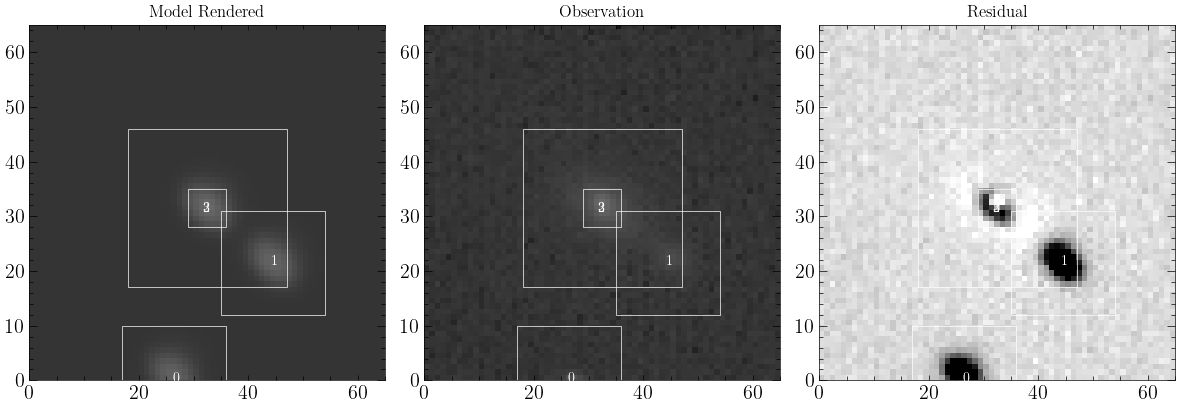

<Figure size 600x450 with 0 Axes>

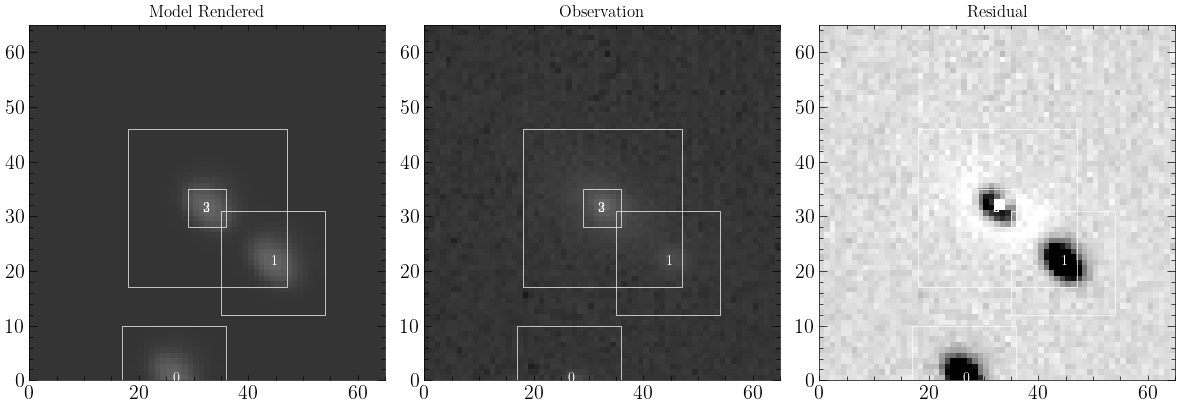

<Figure size 600x450 with 0 Axes>

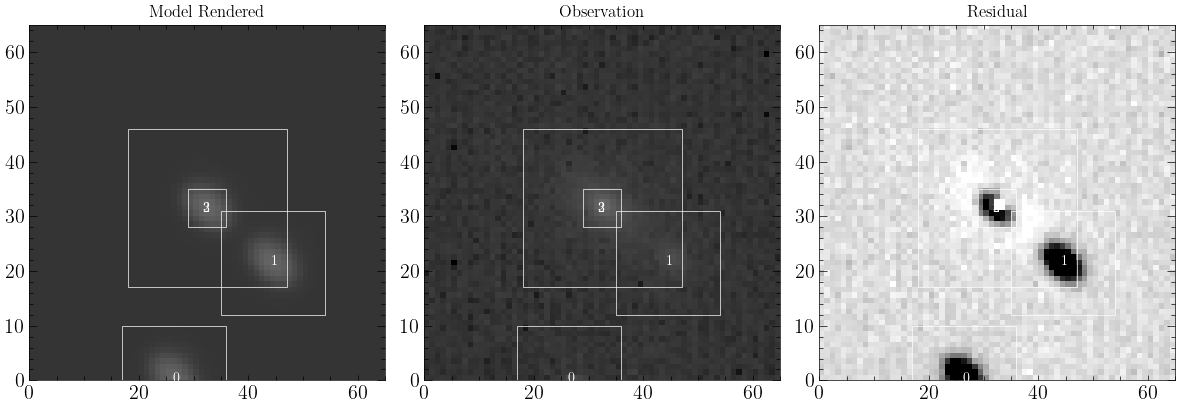

<Figure size 600x450 with 0 Axes>

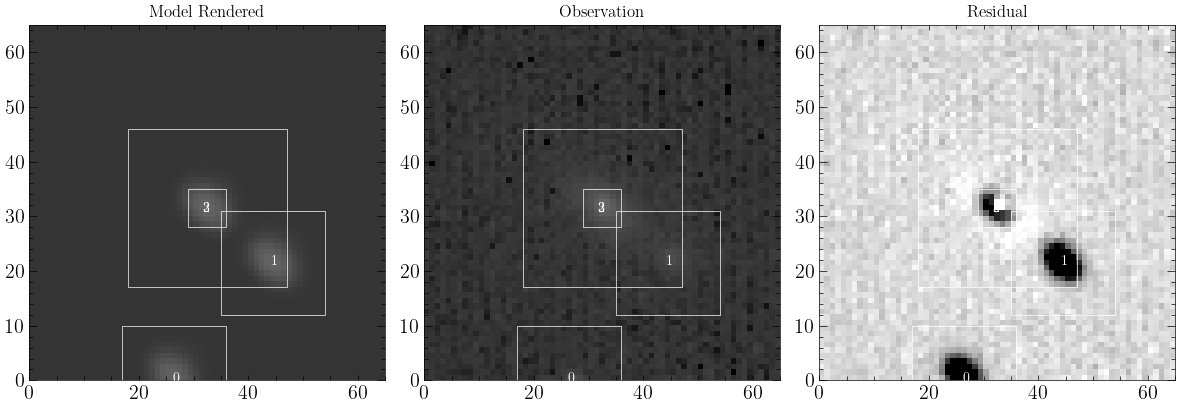

<Figure size 600x450 with 0 Axes>

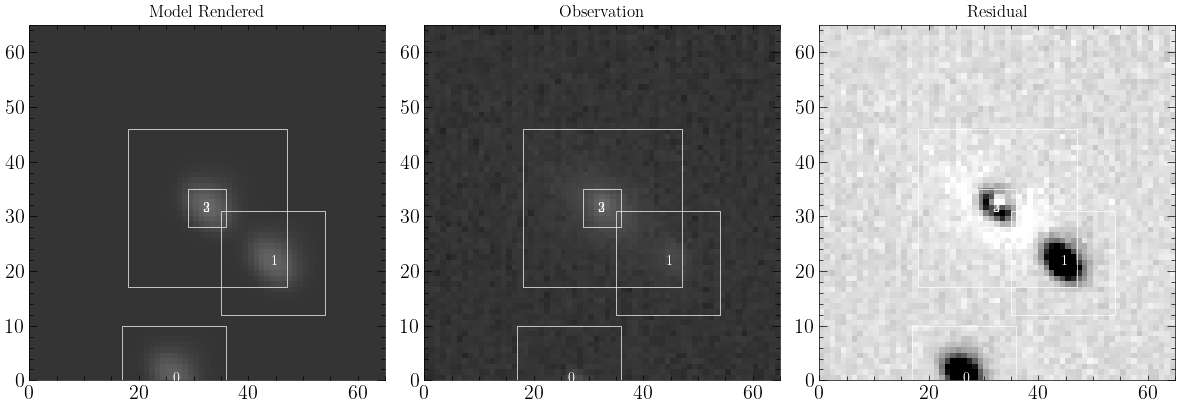

<Figure size 600x450 with 0 Axes>

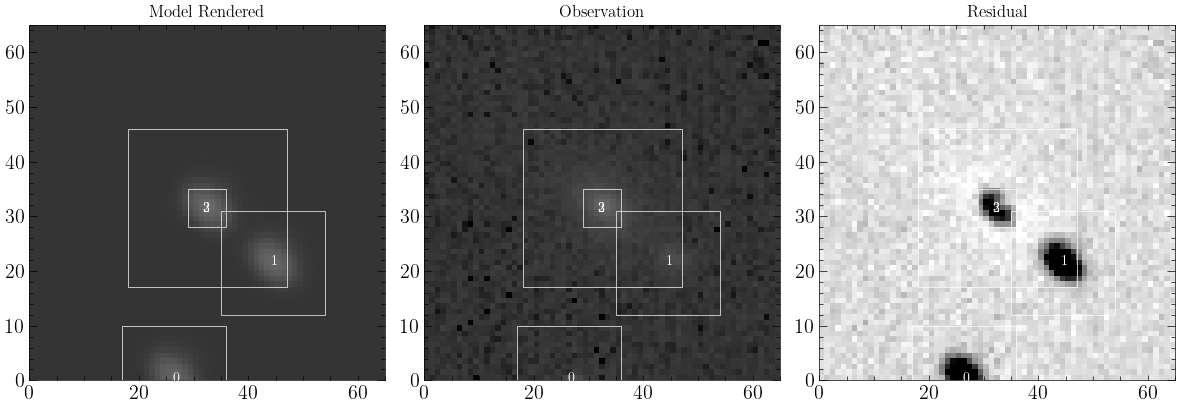

<Figure size 600x450 with 0 Axes>

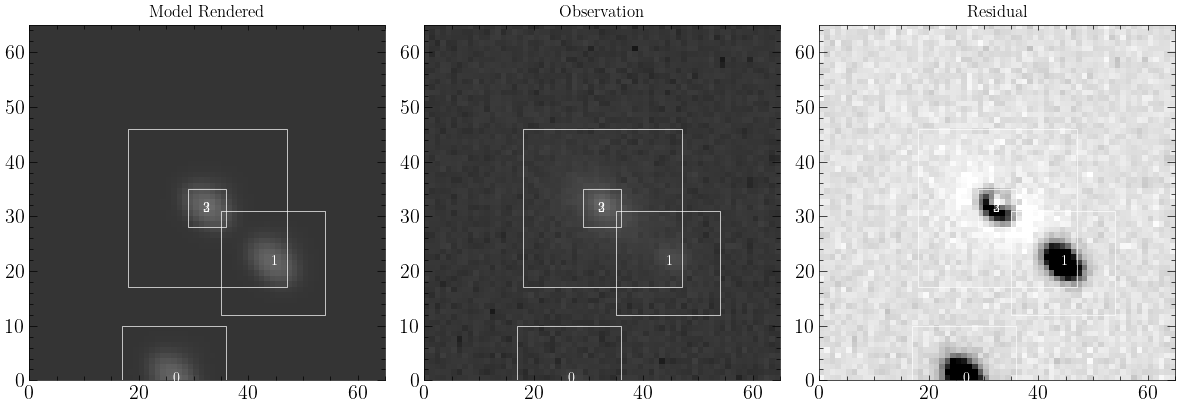

<Figure size 600x450 with 0 Axes>

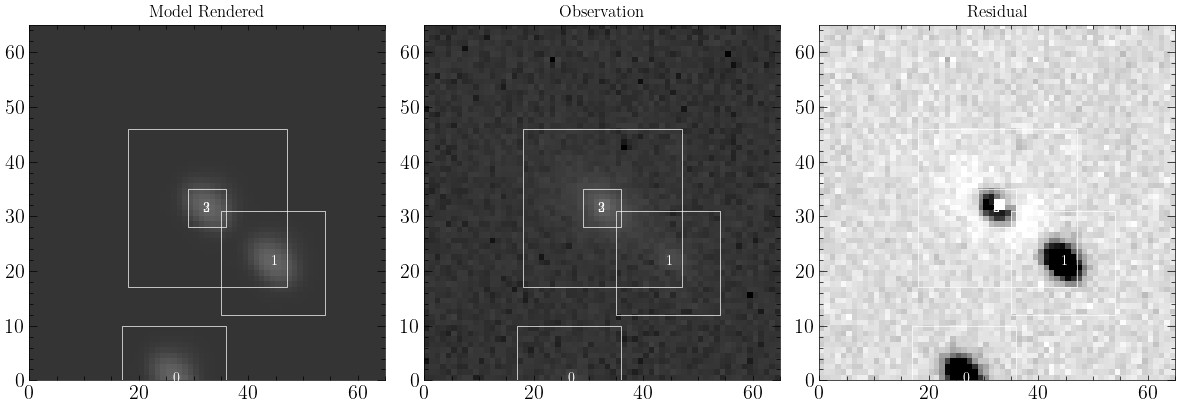

<Figure size 600x450 with 0 Axes>

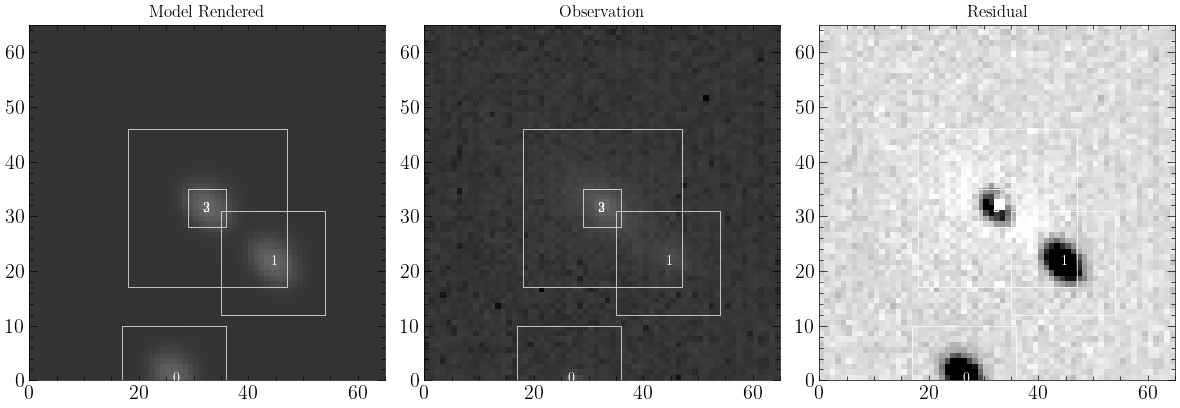

<Figure size 600x450 with 0 Axes>

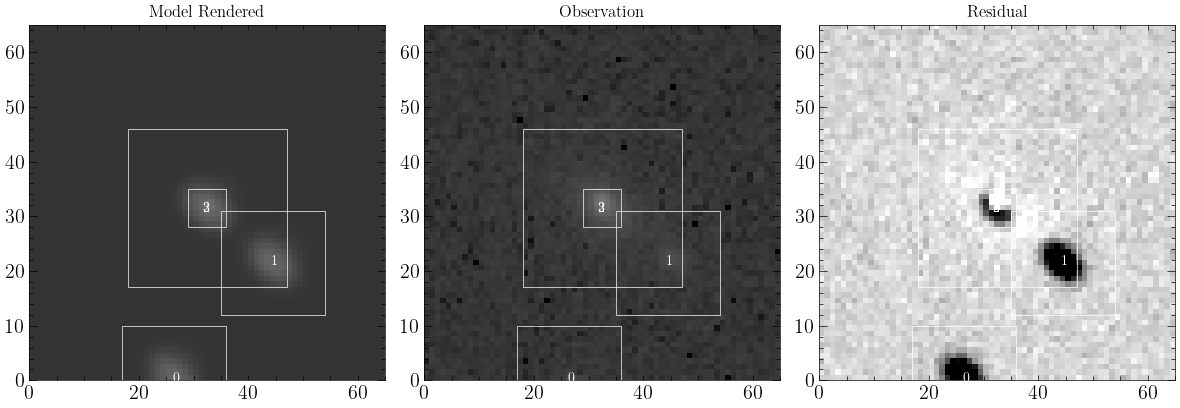

<Figure size 600x450 with 0 Axes>

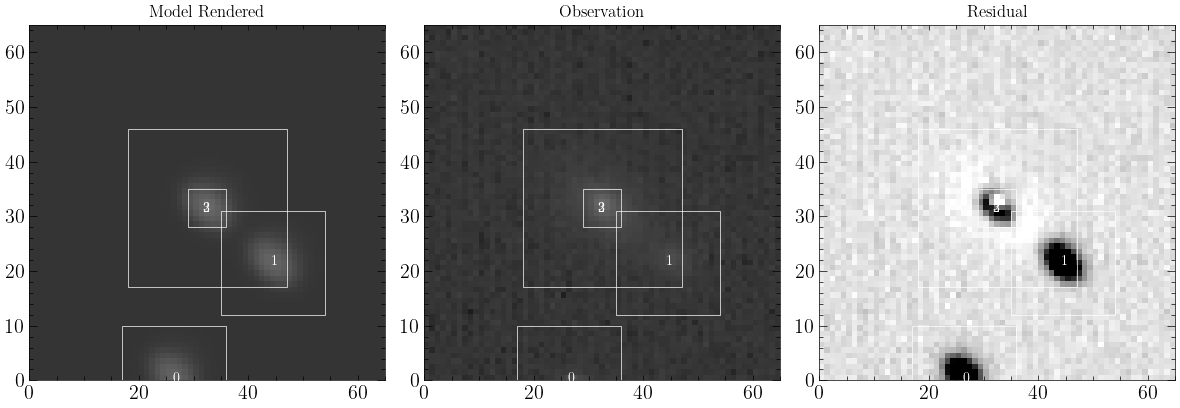

<Figure size 600x450 with 0 Axes>

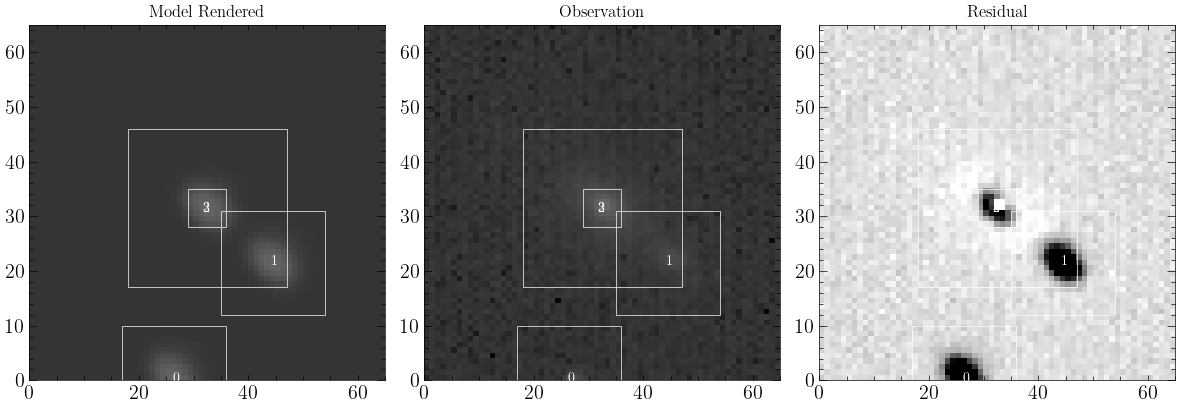

<Figure size 600x450 with 0 Axes>

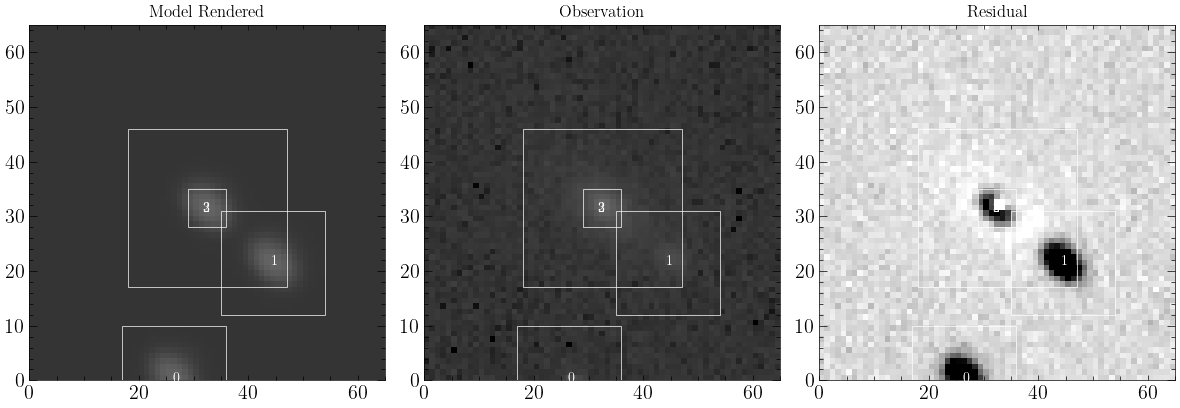

<Figure size 600x450 with 0 Axes>

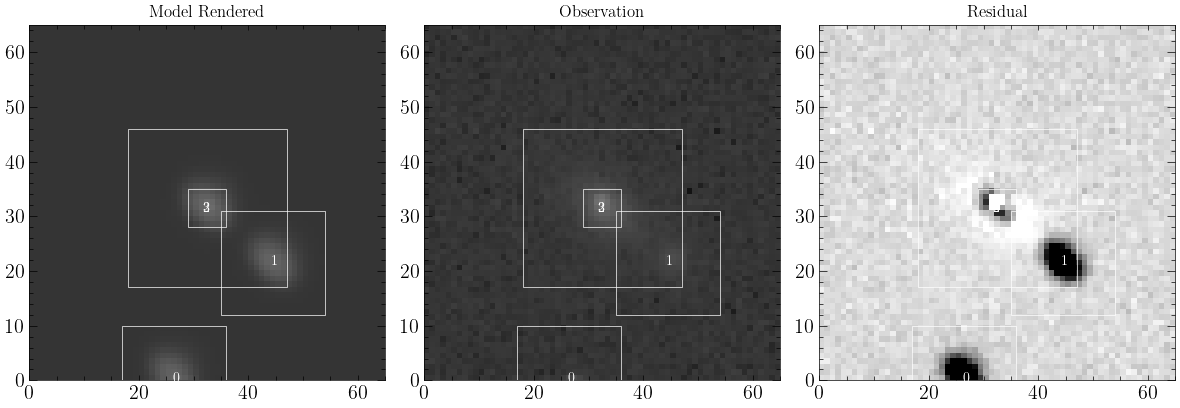

<Figure size 600x450 with 0 Axes>

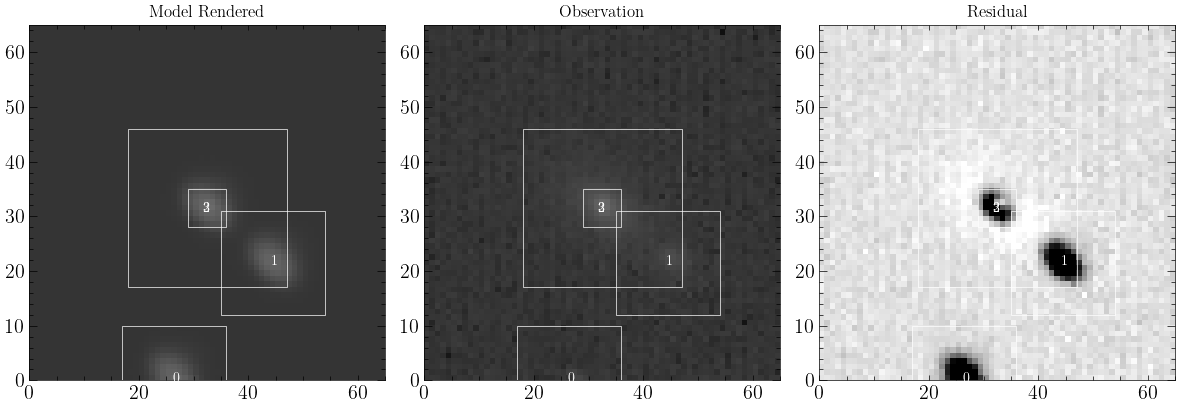

<Figure size 600x450 with 0 Axes>

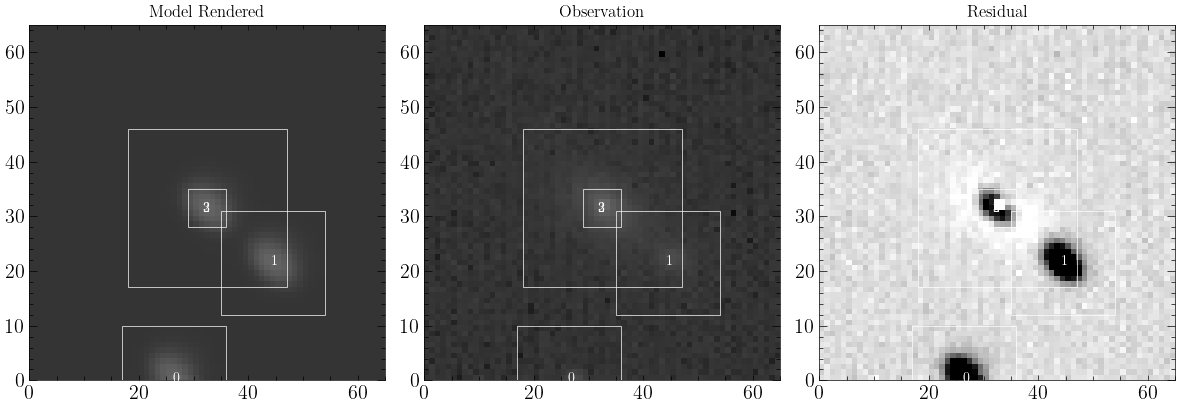

<Figure size 600x450 with 0 Axes>

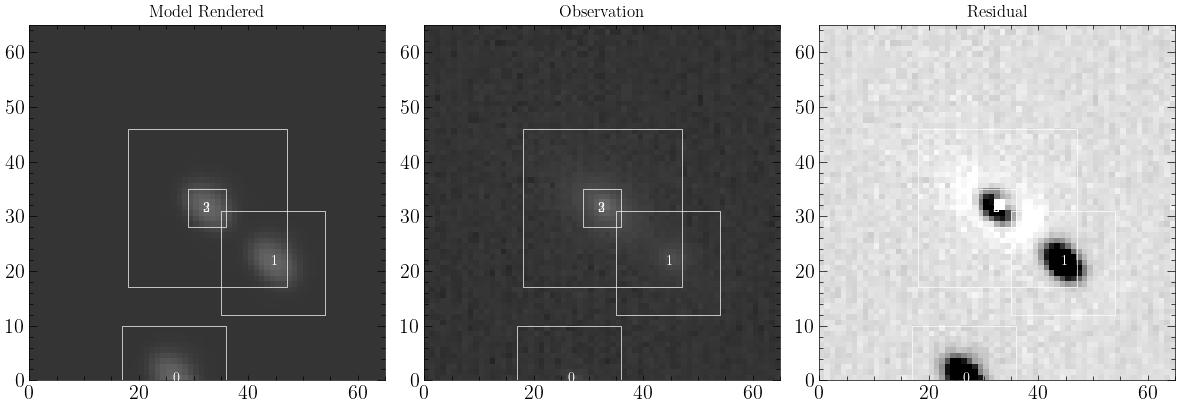

<Figure size 600x450 with 0 Axes>

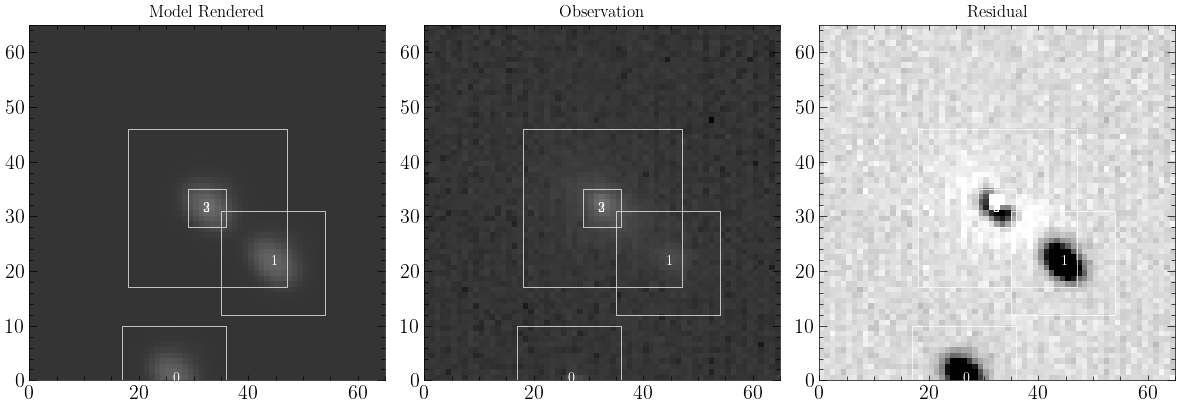

<Figure size 600x450 with 0 Axes>

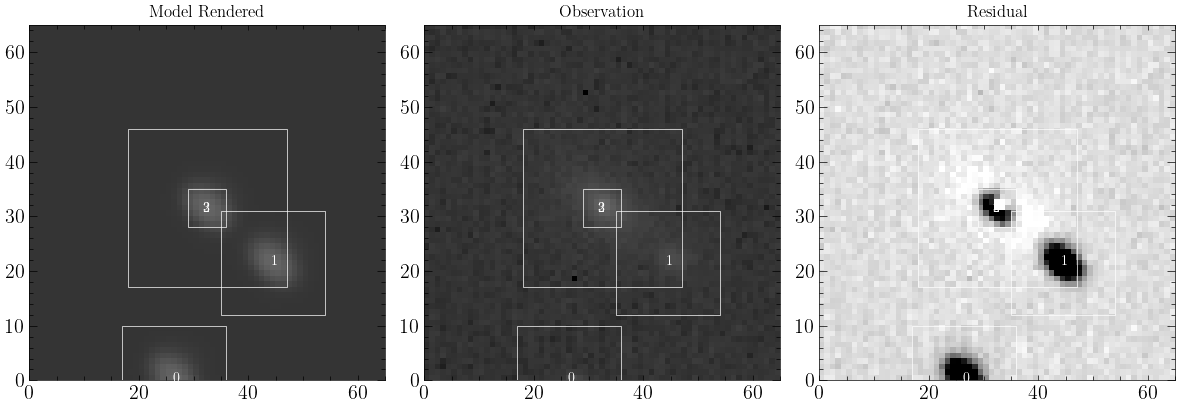

<Figure size 600x450 with 0 Axes>

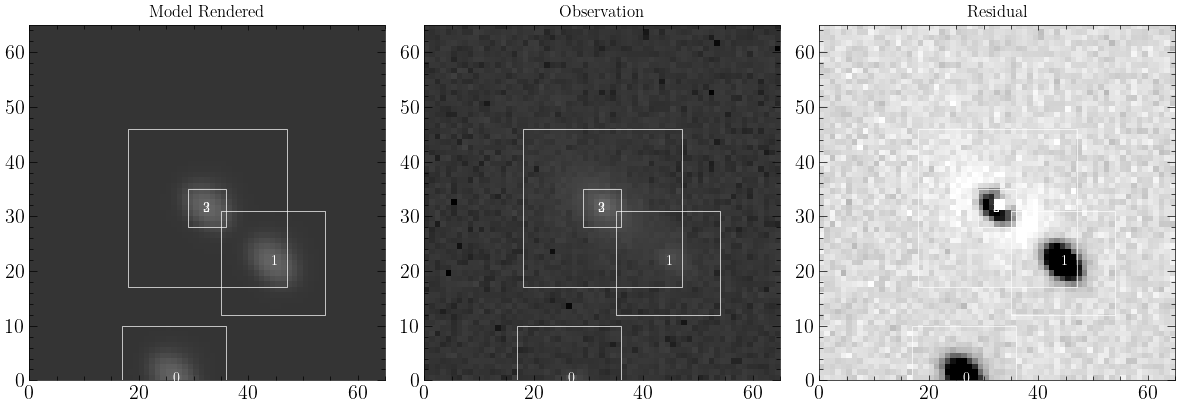

<Figure size 600x450 with 0 Axes>

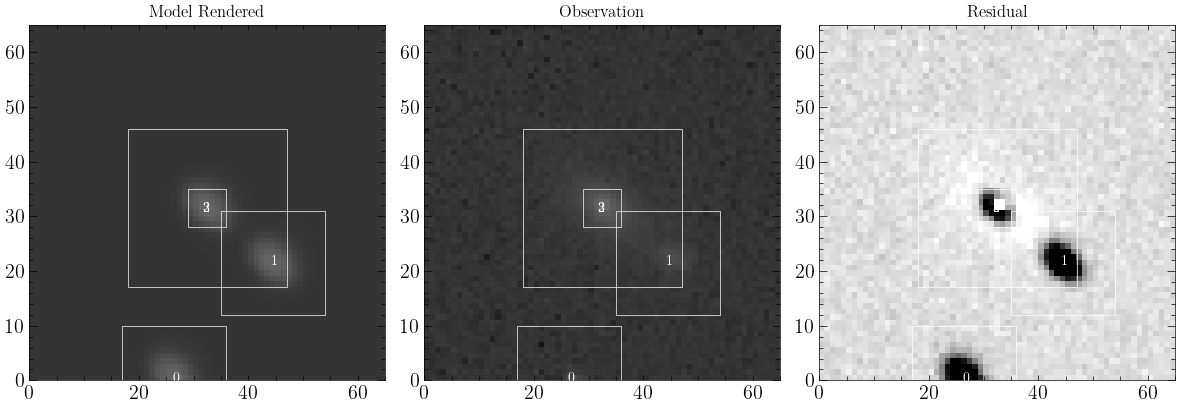

<Figure size 600x450 with 0 Axes>

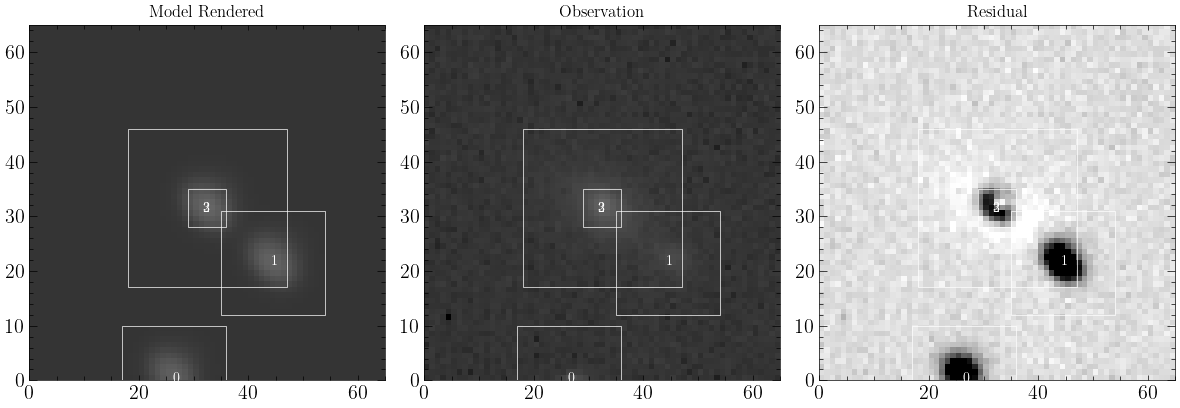

<Figure size 600x450 with 0 Axes>

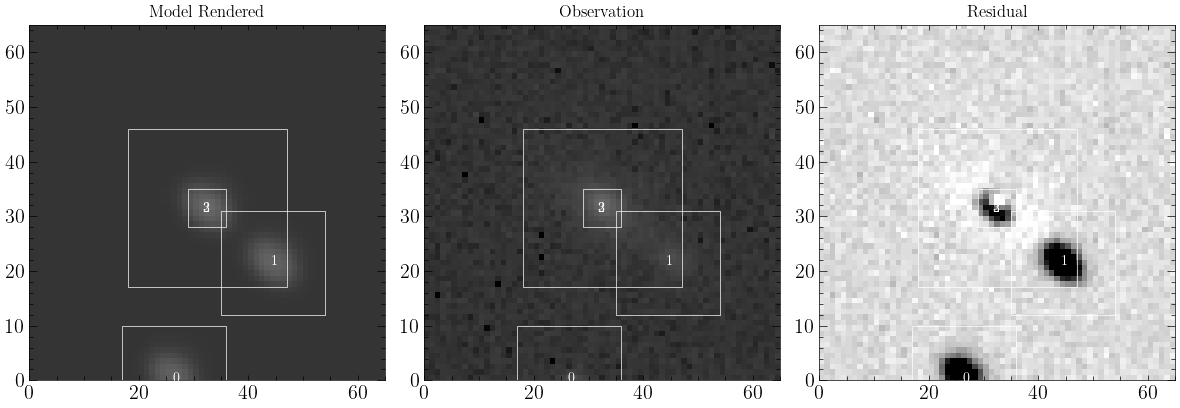

<Figure size 600x450 with 0 Axes>

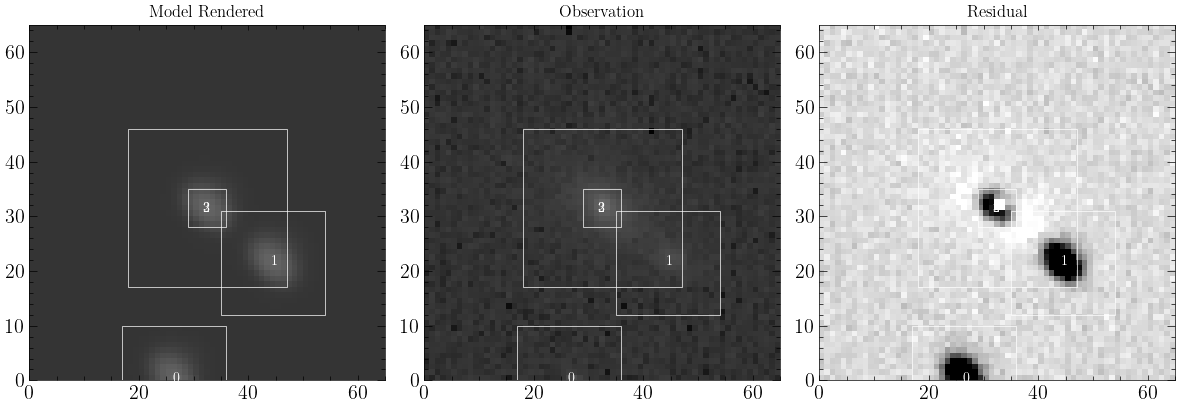

<Figure size 600x450 with 0 Axes>

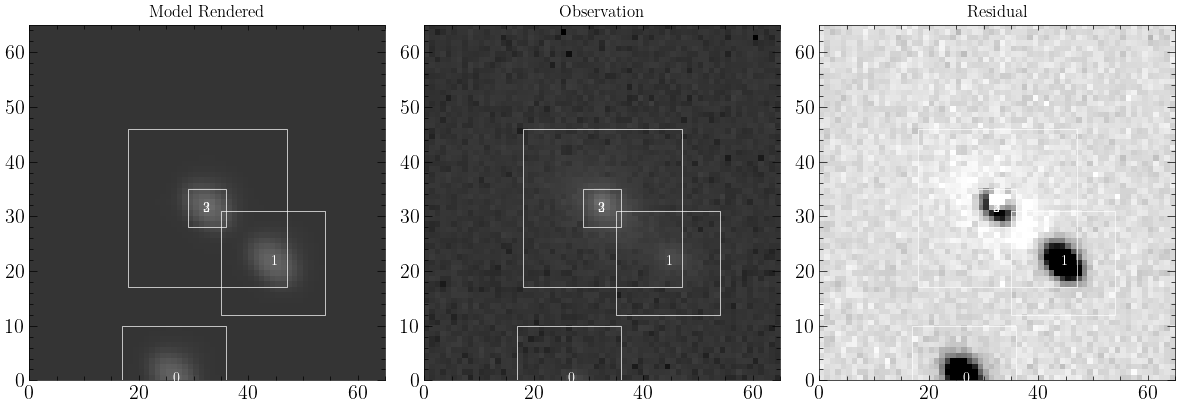

<Figure size 600x450 with 0 Axes>

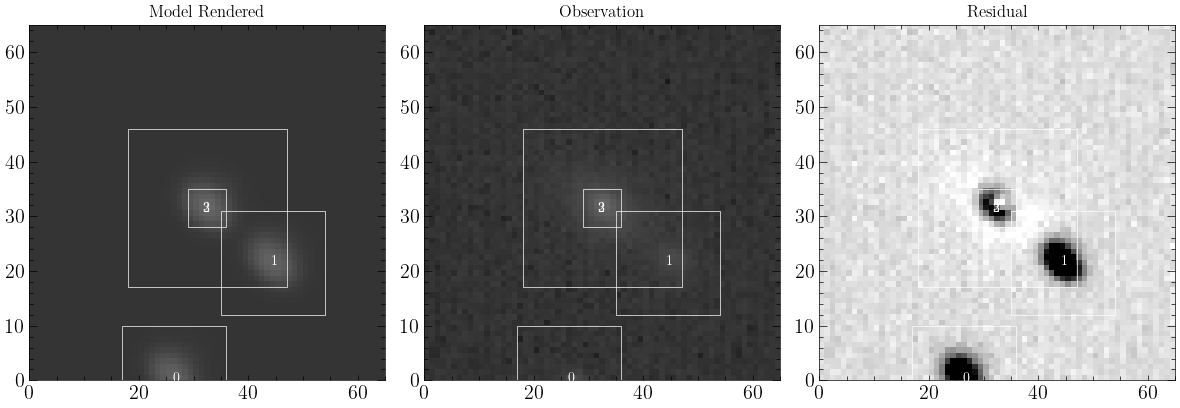

<Figure size 600x450 with 0 Axes>

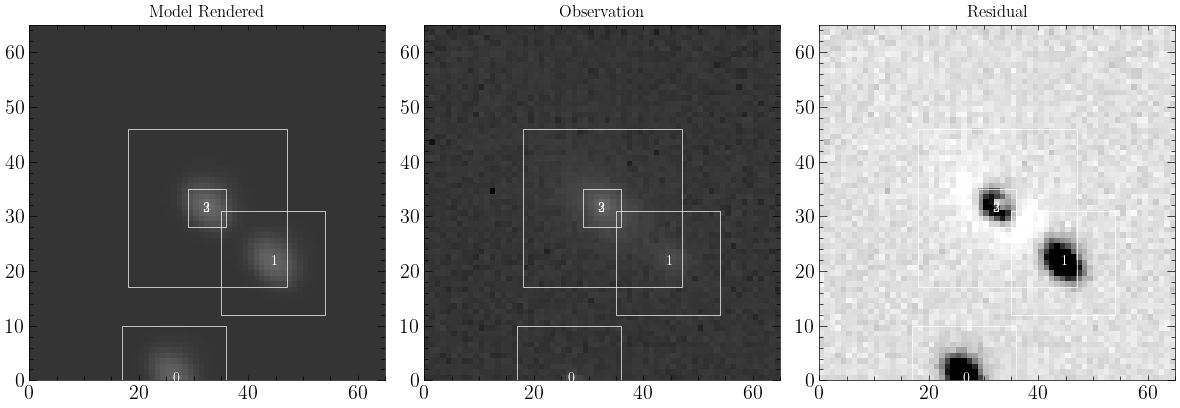

<Figure size 600x450 with 0 Axes>

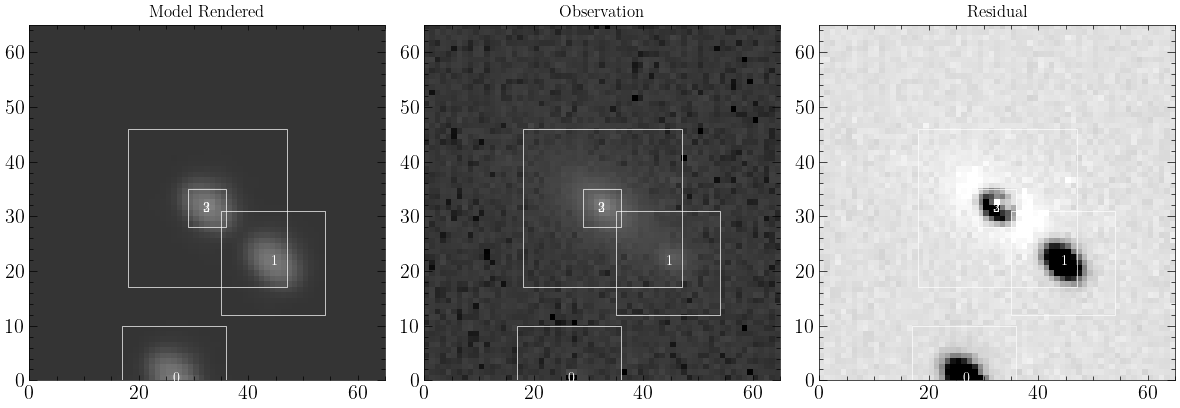

<Figure size 600x450 with 0 Axes>

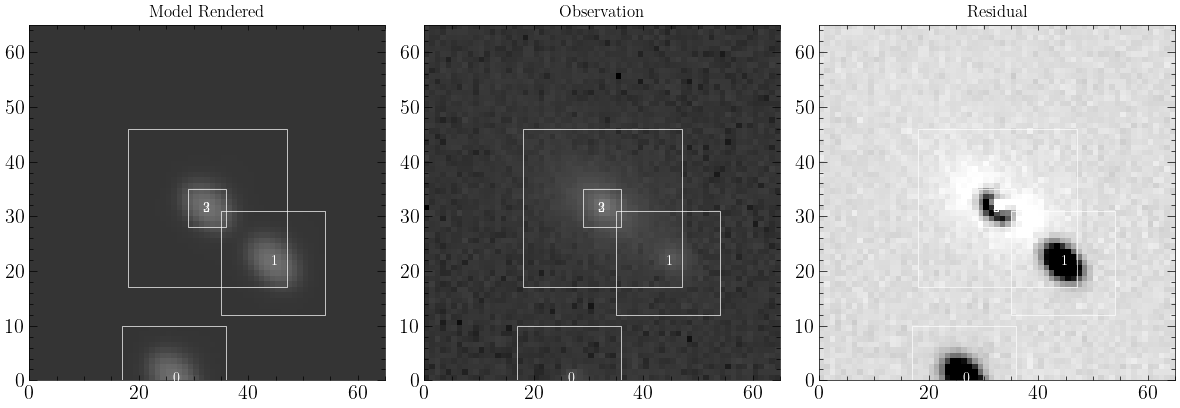

<Figure size 600x450 with 0 Axes>

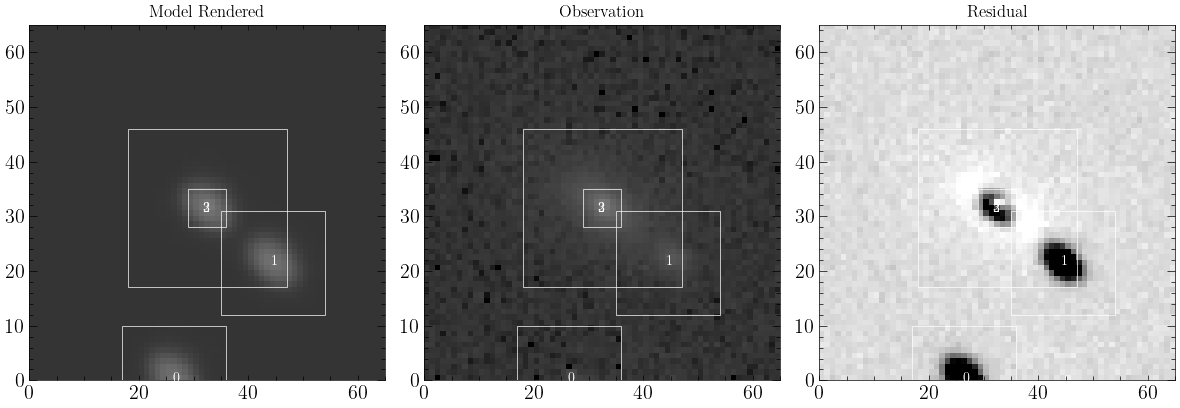

<Figure size 600x450 with 0 Axes>

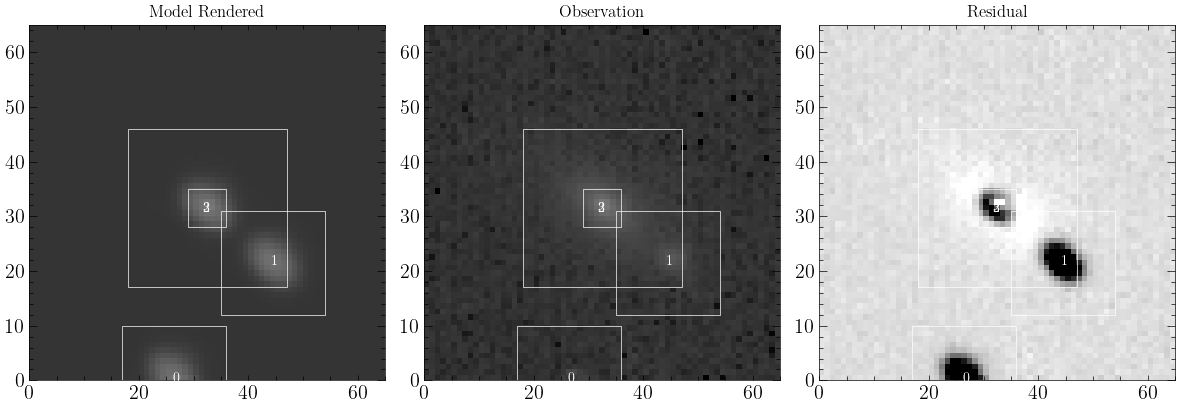

<Figure size 600x450 with 0 Axes>

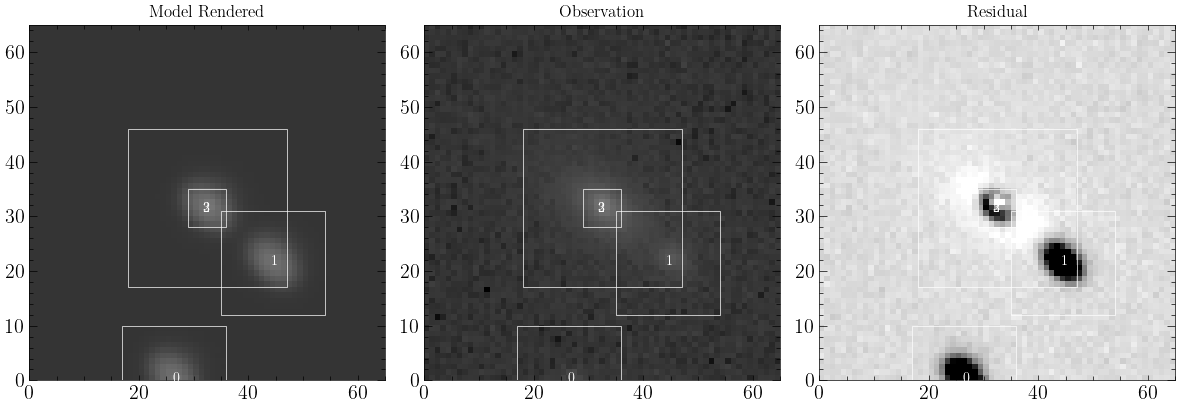

<Figure size 600x450 with 0 Axes>

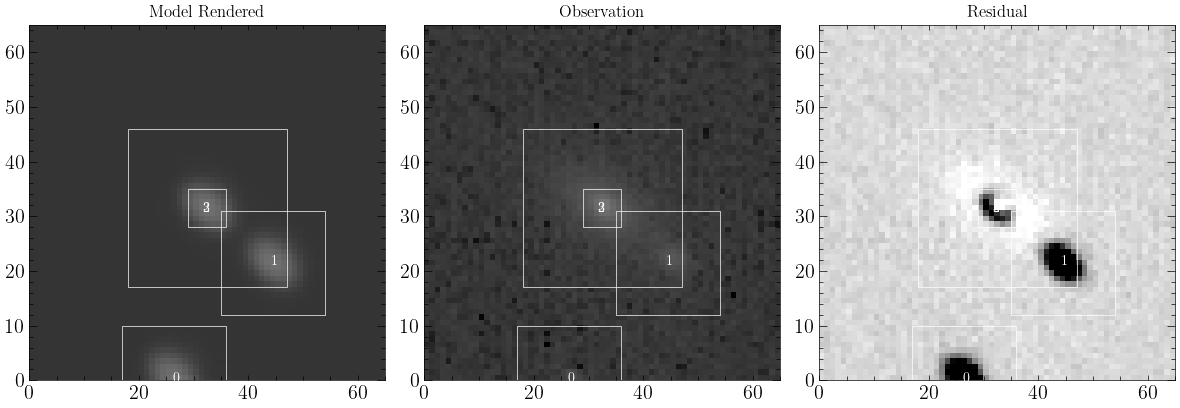

<Figure size 600x450 with 0 Axes>

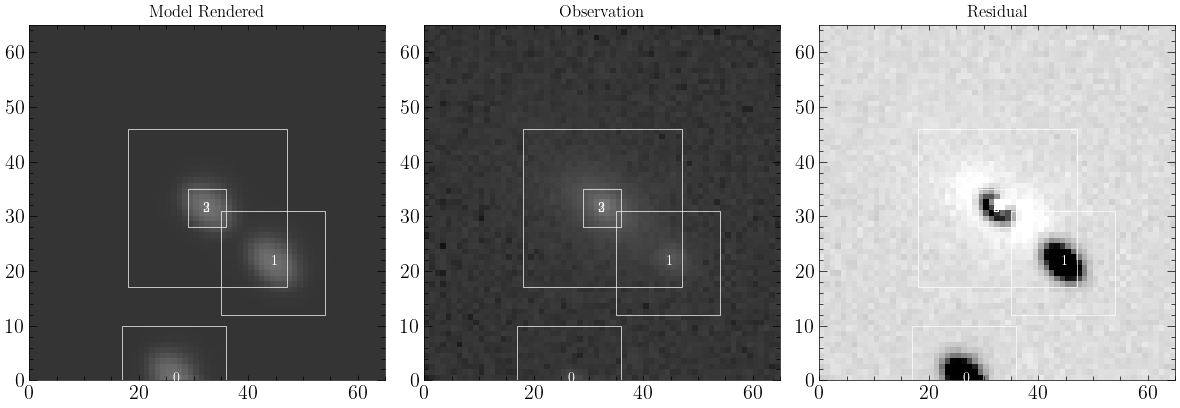

<Figure size 600x450 with 0 Axes>

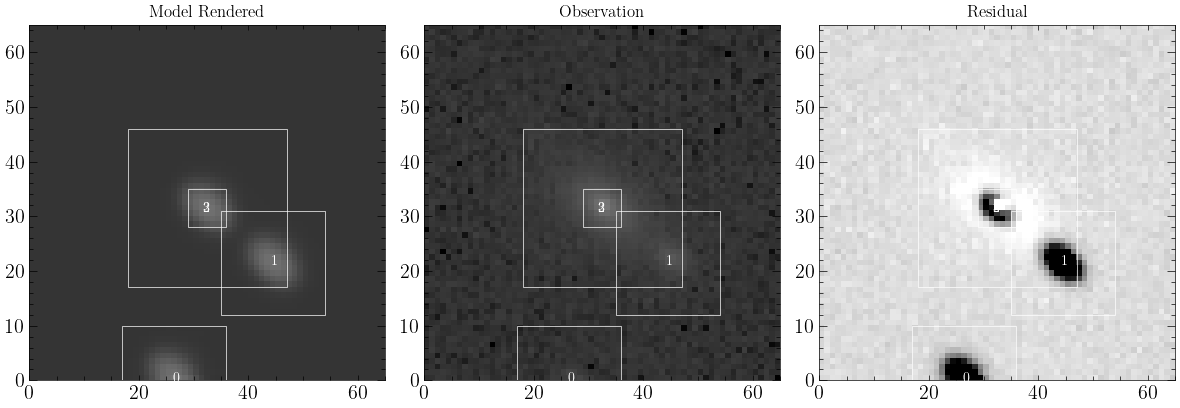

<Figure size 600x450 with 0 Axes>

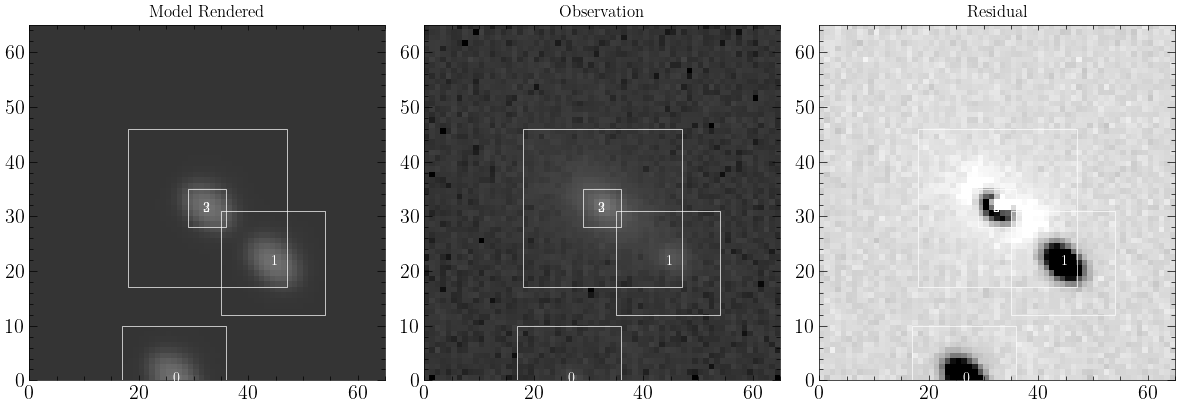

<Figure size 600x450 with 0 Axes>

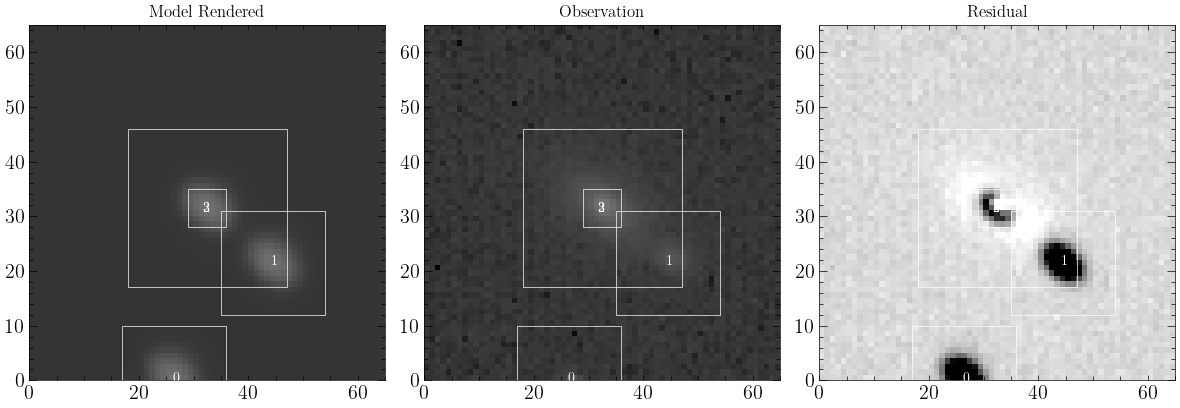

<Figure size 600x450 with 0 Axes>

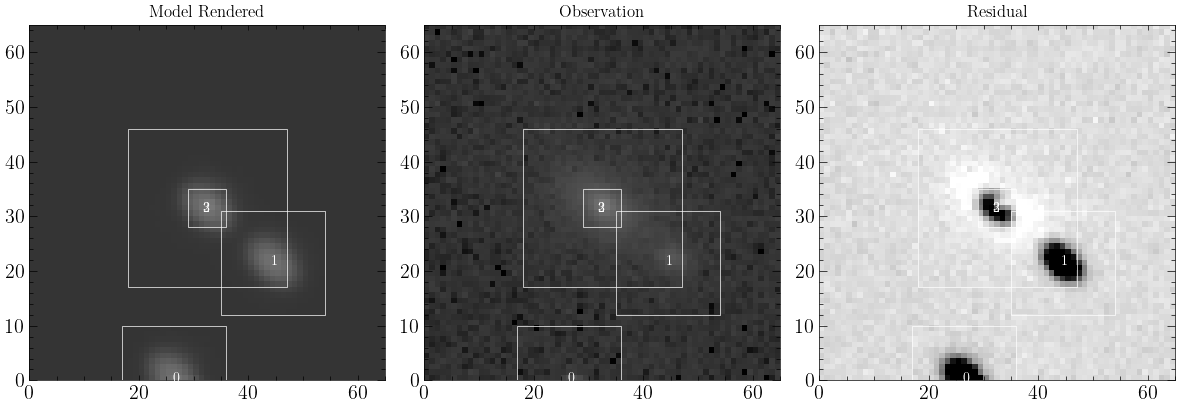

<Figure size 600x450 with 0 Axes>

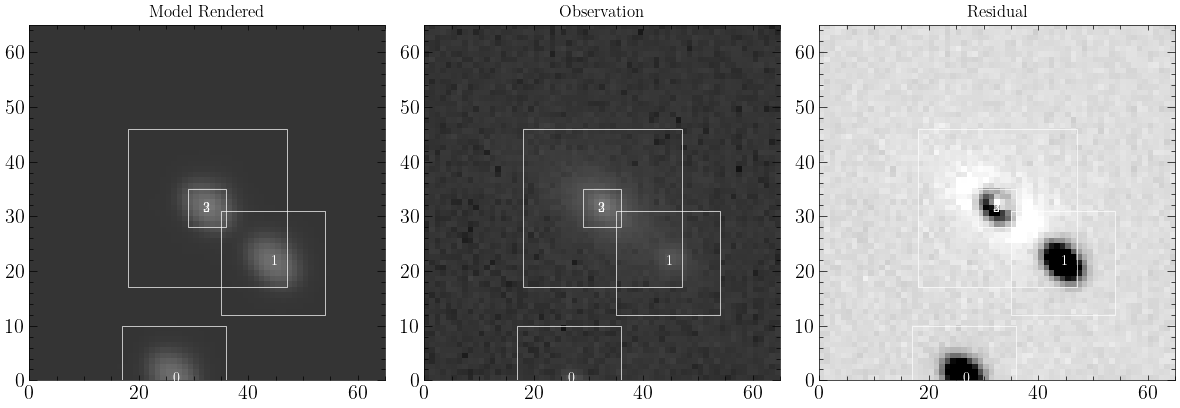

<Figure size 600x450 with 0 Axes>

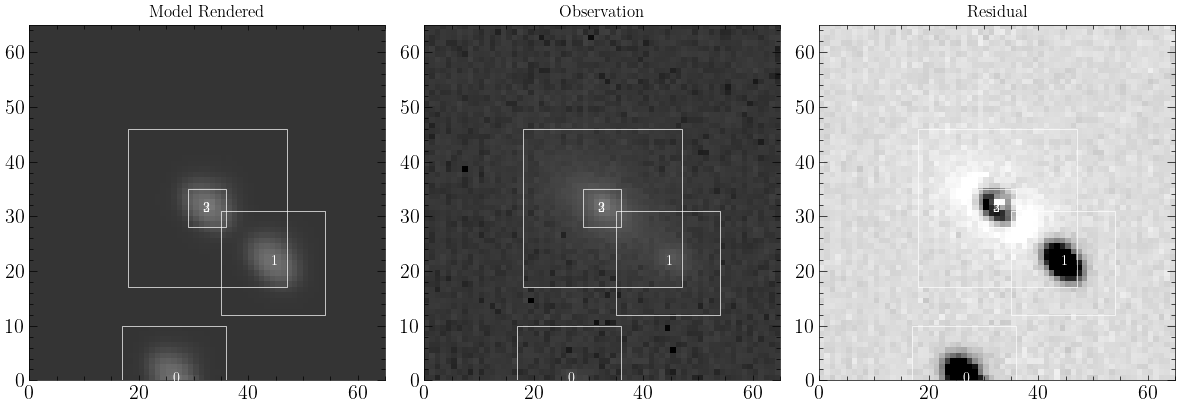

<Figure size 600x450 with 0 Axes>

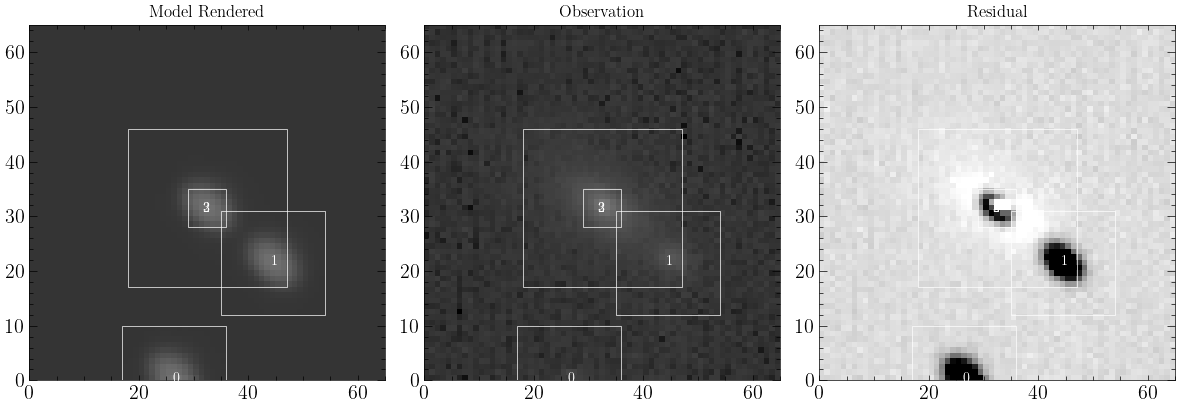

<Figure size 600x450 with 0 Axes>

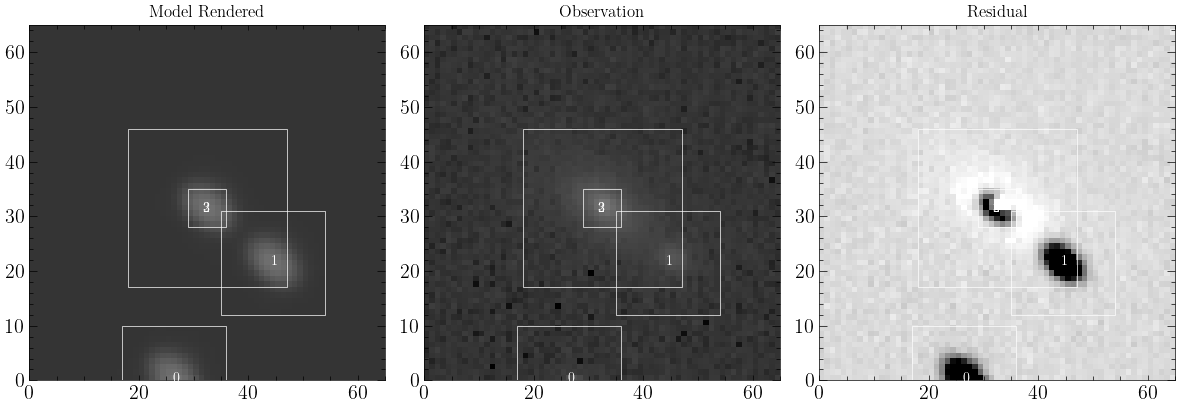

<Figure size 600x450 with 0 Axes>

In [12]:
for i,obs in enumerate(observations_sc2):
    scarlet2.plot.scene(
        scene,
        observation=obs,#np.asarray(observations_sc2),
        norm=normsingle[-1],
        channel_map=None,#np.asarray(channels_sc2[:1]),#[:1],#inds0],
        show_model=False,
        show_observed=True,
        show_rendered=True,
        show_residual=True,
        add_labels=True,
        add_boxes=True,
        #figsize=None,
        linear=True,
    )
    plt.show()
    plt.clf()

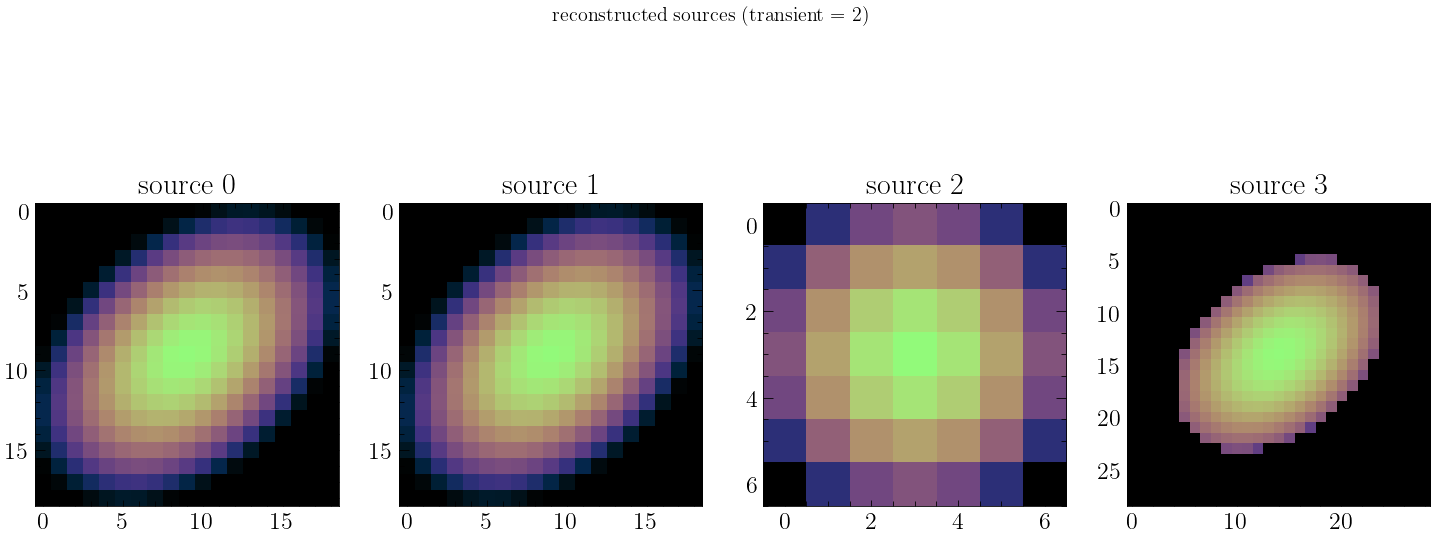

<Figure size 600x450 with 0 Axes>

In [13]:
#Show the initalization point source and host galaxy models
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene.sources[i].morphology()
    else:
        y = scene.sources[i].morphology.data
    ax.imshow(np.log(y), cmap = cmap,interpolation=int_method)#,vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.show()
plt.clf()

Plot scarlet2 initializations

In [14]:
n_steps, peak_value = stepnum, 1
schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
flux = scene.sources[indtransient].spectrum.data

#Fit the scene
#with open('TDEmodel.pkl','rb') as f:
#    scene_ = pickle.load(f)
scene_ = scene.fit(observations_sc2, parameters,max_iter=stepnum, e_rel=1e-6, schedule=schedule)

In [15]:
#with open('TDEmodel.pkl','wb') as f:
#    pickle.dump(scene_,f)

(1, 65, 65)
SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_0_modelexample.png


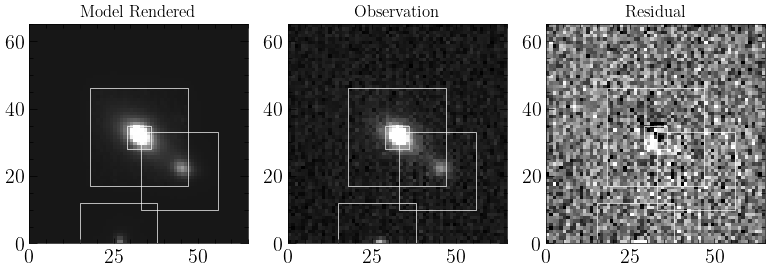

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_1_modelexample.png


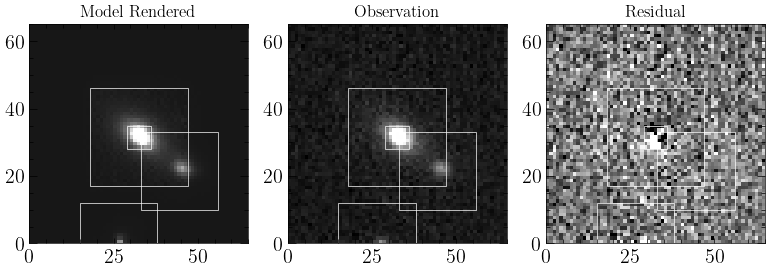

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_2_modelexample.png


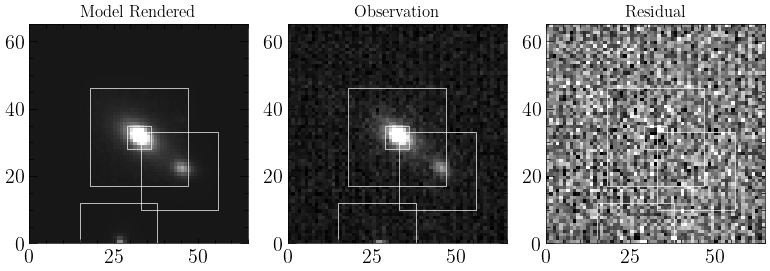

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_3_modelexample.png


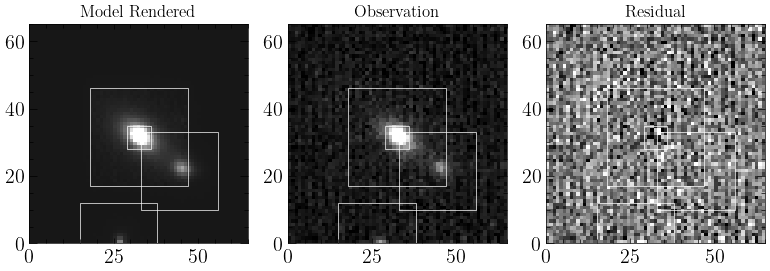

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_4_modelexample.png


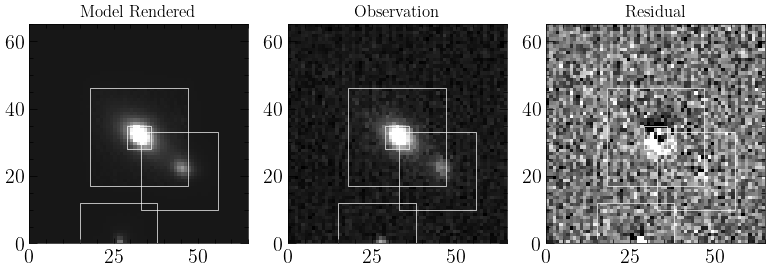

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_5_modelexample.png


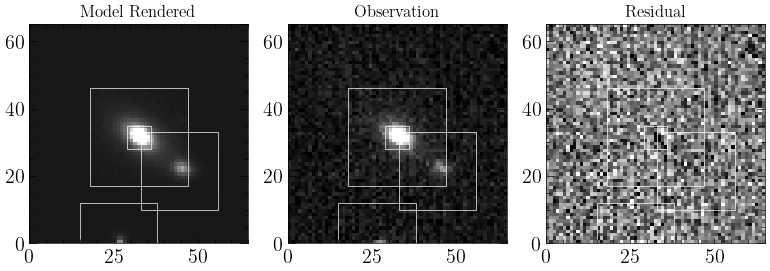

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_6_modelexample.png


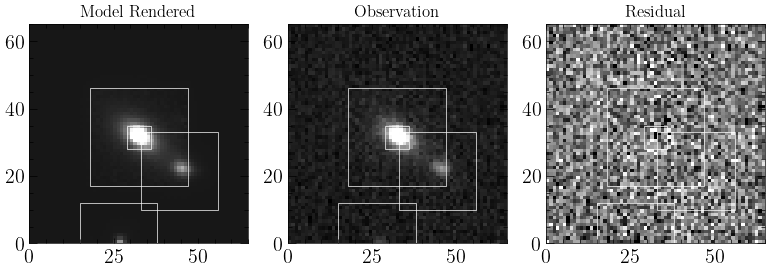

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_7_modelexample.png


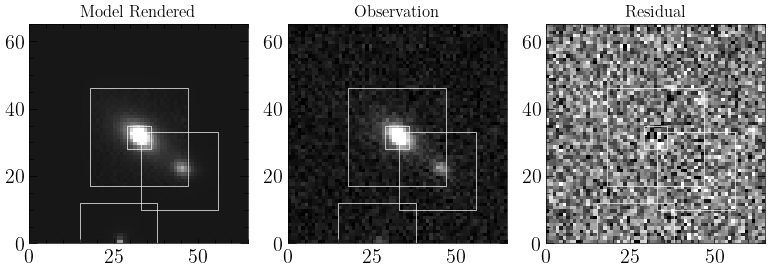

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_8_modelexample.png


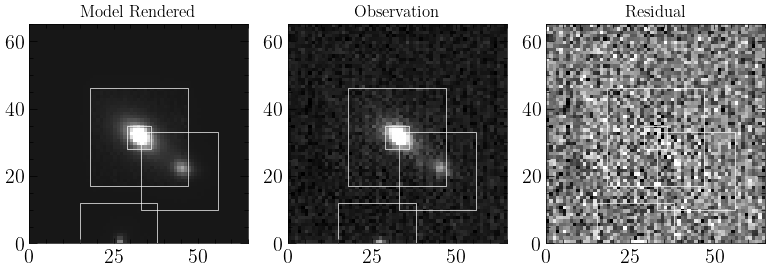

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_9_modelexample.png


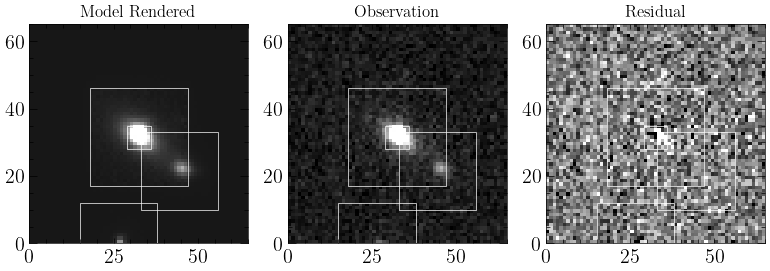

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_10_modelexample.png


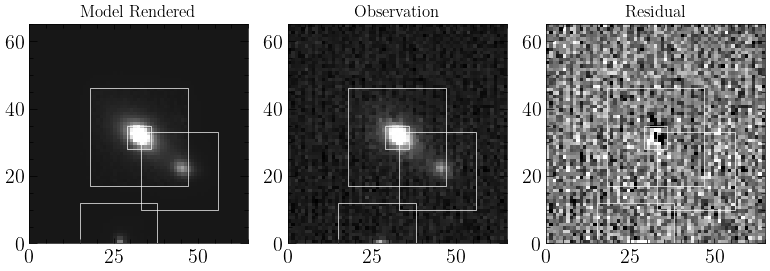

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_11_modelexample.png


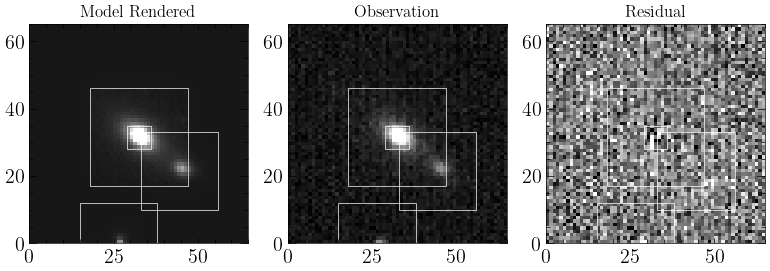

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_12_modelexample.png


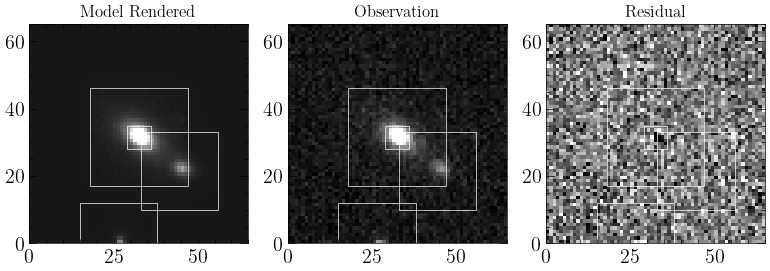

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_13_modelexample.png


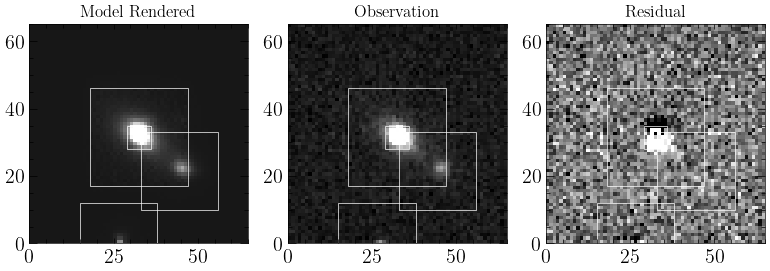

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_14_modelexample.png


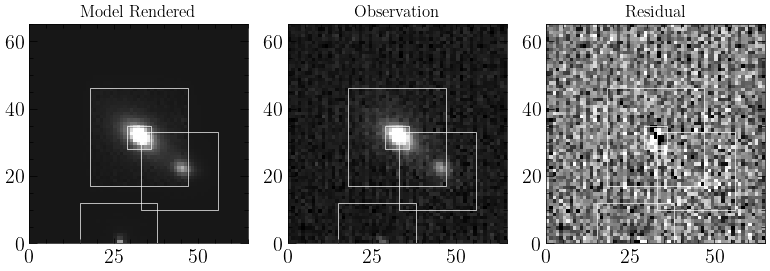

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_15_modelexample.png


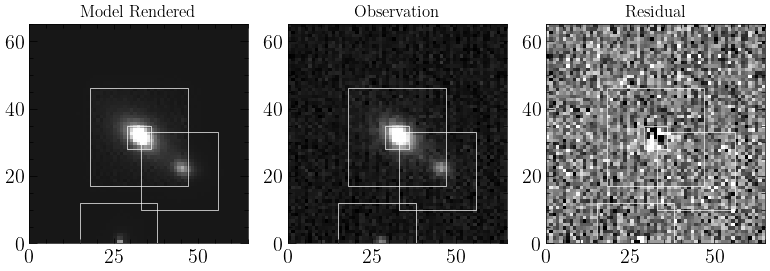

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_16_modelexample.png


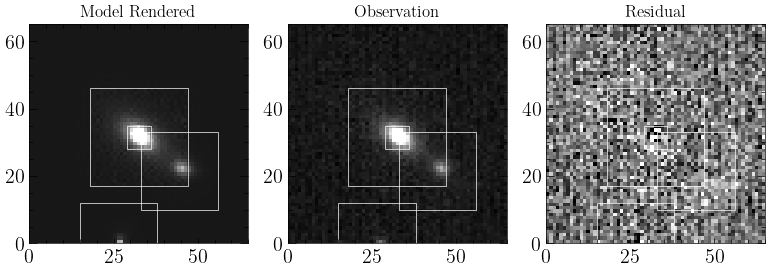

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_17_modelexample.png


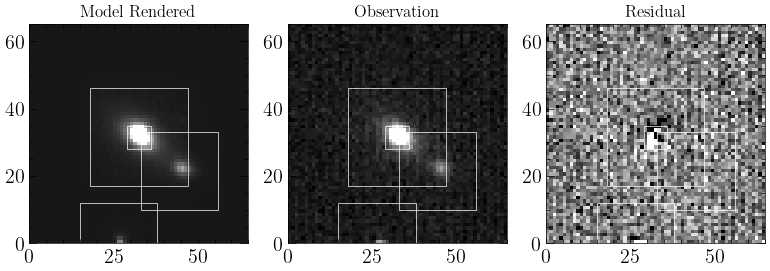

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_18_modelexample.png


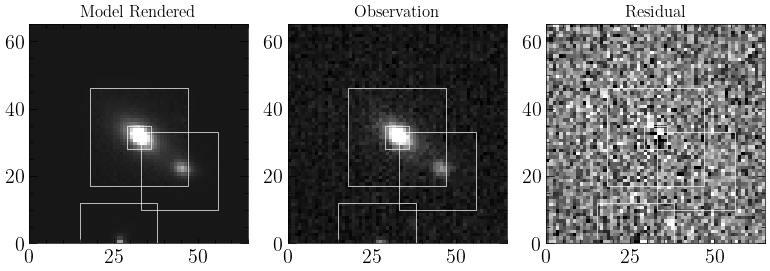

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_19_modelexample.png


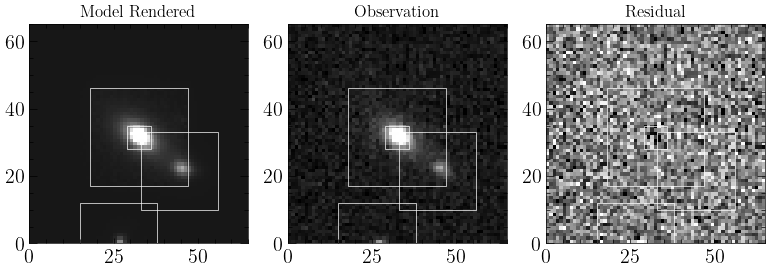

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_20_modelexample.png


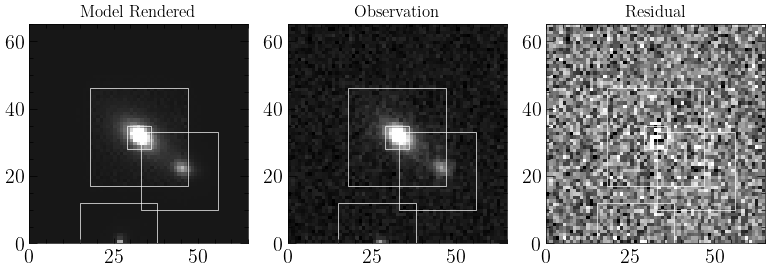

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_21_modelexample.png


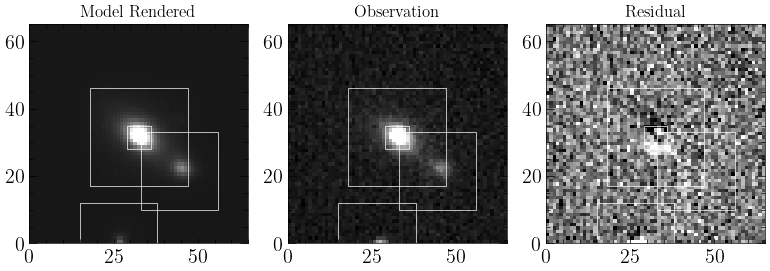

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_22_modelexample.png


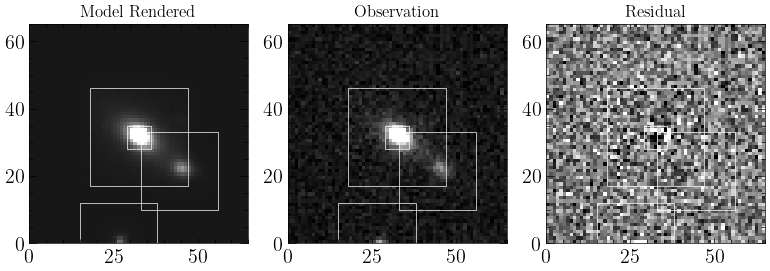

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_23_modelexample.png


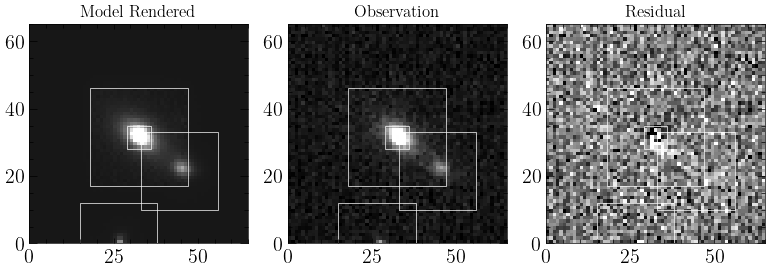

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_24_modelexample.png


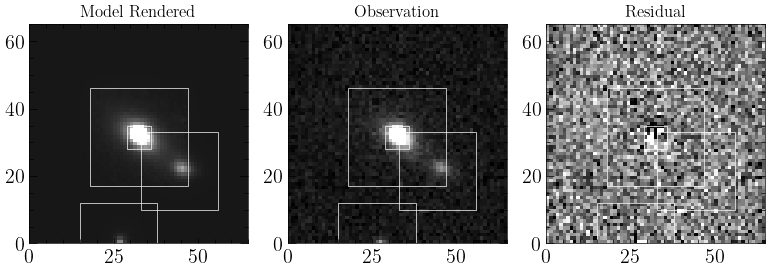

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_25_modelexample.png


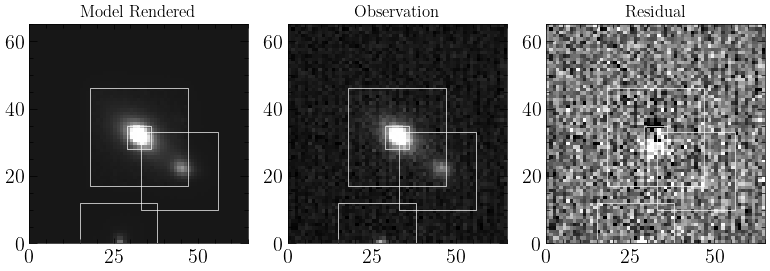

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_26_modelexample.png


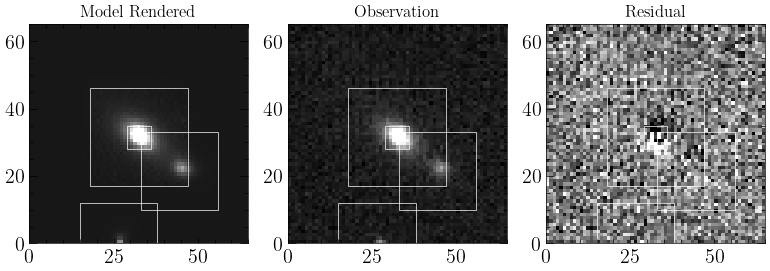

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_27_modelexample.png


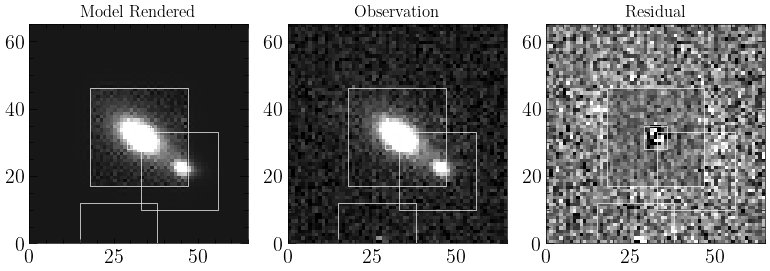

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_28_modelexample.png


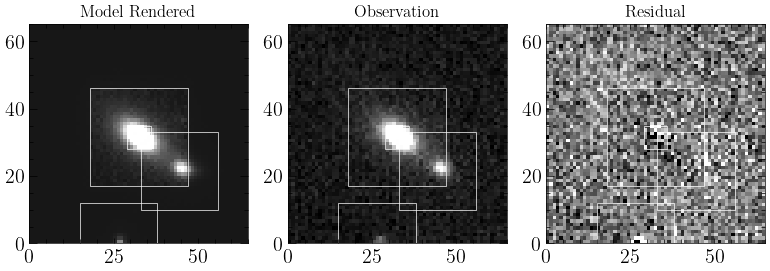

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_29_modelexample.png


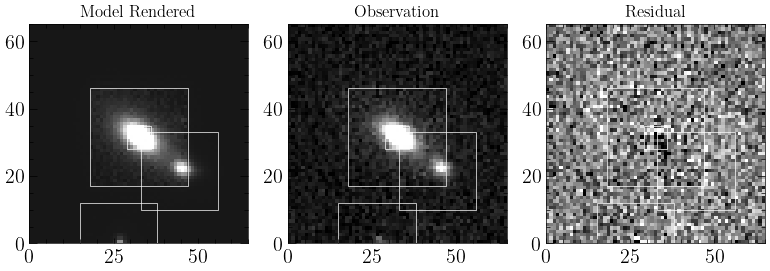

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_30_modelexample.png


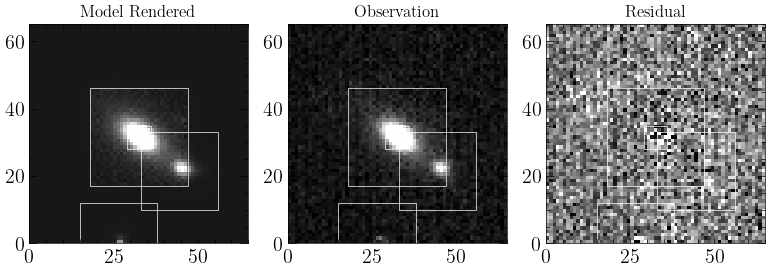

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_31_modelexample.png


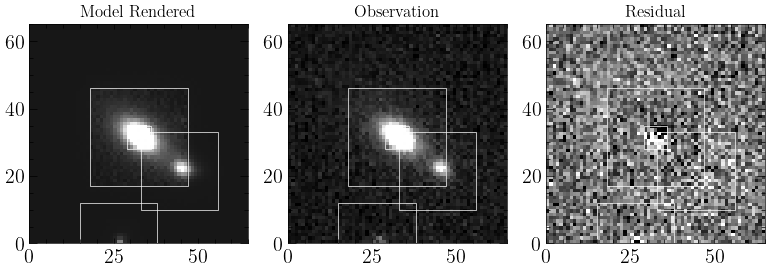

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_32_modelexample.png


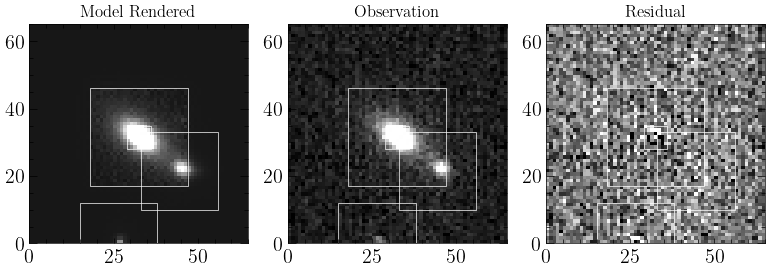

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_33_modelexample.png


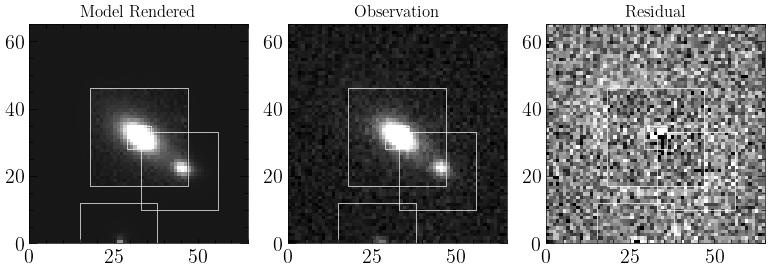

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_34_modelexample.png


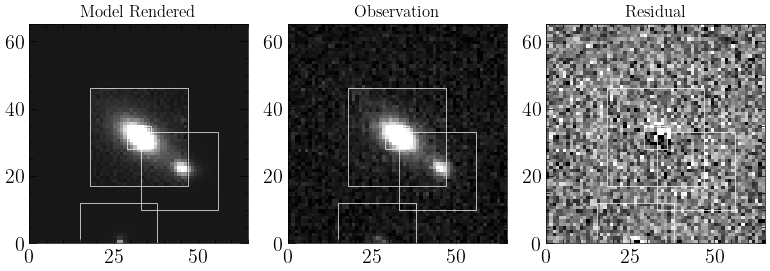

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_35_modelexample.png


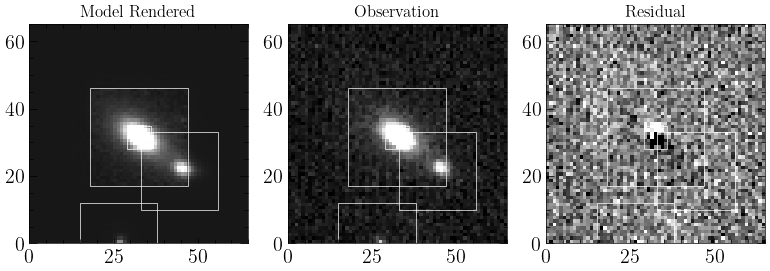

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_36_modelexample.png


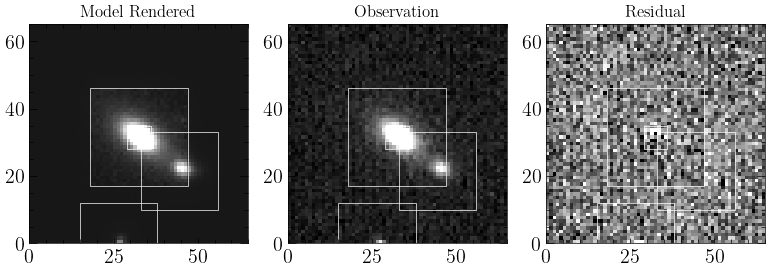

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_37_modelexample.png


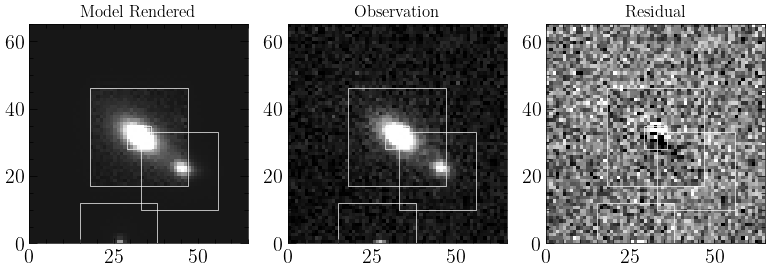

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_38_modelexample.png


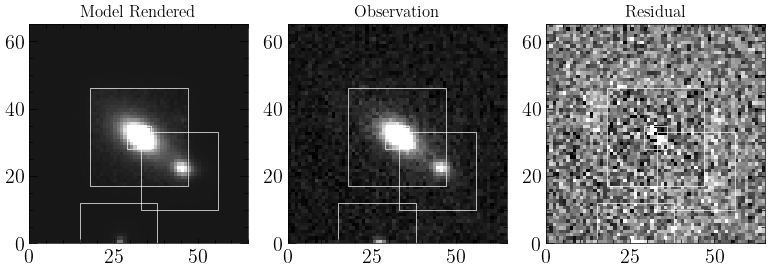

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_39_modelexample.png


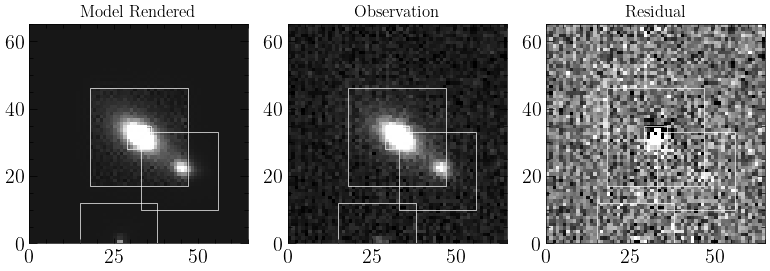

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_40_modelexample.png


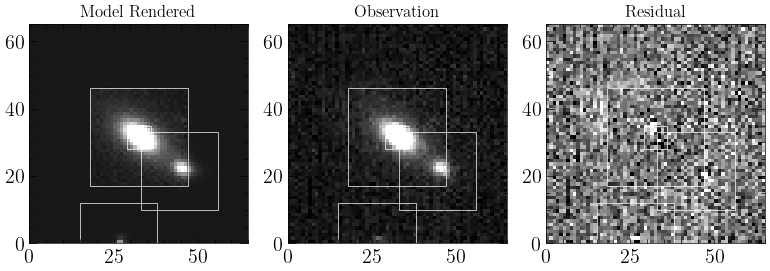

SAVED /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_41_modelexample.png


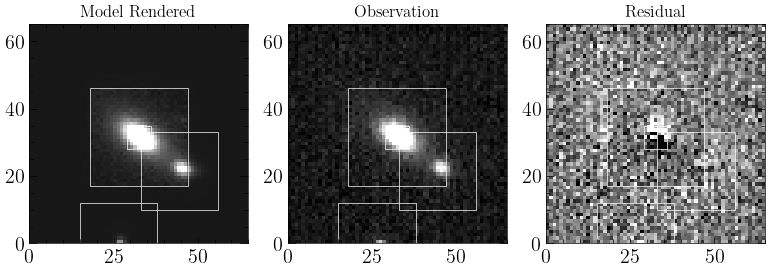

In [16]:
print(observations_sc2[0].data.shape)
for i,obs in enumerate(observations_sc2):
    scarlet2.plot.scene(
        scene_,
        observation=obs,
        norm=LinearPercentileNorm(observations_sc2[0].data,percentiles=[0.1, 99.5]),
        channel_map=None,
        show_model=False,
        show_observed=True,
        show_rendered=True,
        show_residual=True,
        add_labels=False,
        add_boxes=True,
        #figsize=None,
        linear=True,
        fig_kwargs={'figsize':(7.9,2.9)}
    )


    plt.savefig(plotdir+'/'+srcname+'_'+str(i)+'_modelexample.png')
    print('SAVED',plotdir+'/'+srcname+'_'+str(i)+'_modelexample.png')
    plt.show()

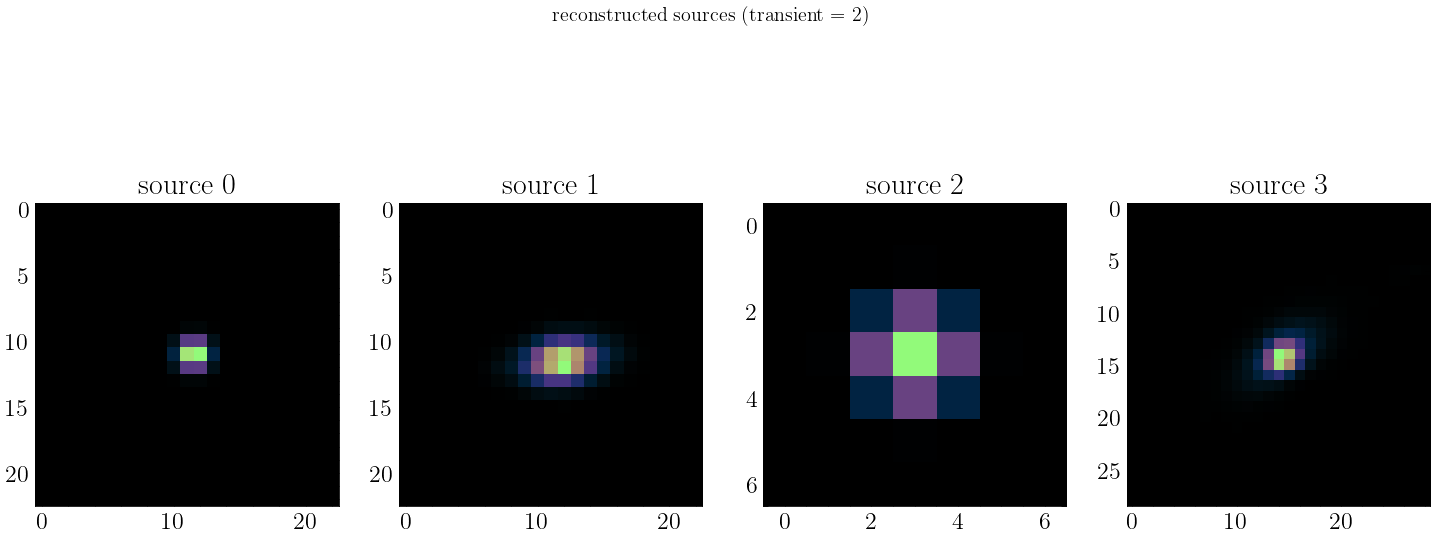

<Figure size 600x450 with 0 Axes>

In [17]:
#Show the point source and host galaxy models
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene_.sources[i].morphology()
    else:
        y = scene_.sources[i].morphology.data
    ax.imshow(y, cmap = cmap,interpolation=int_method)#,vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
plt.savefig(plotdir+'/'+srcname+'_reconstructed_sources.png')
plt.show()
plt.clf()

/scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_reconstructed_galaxy.pdf


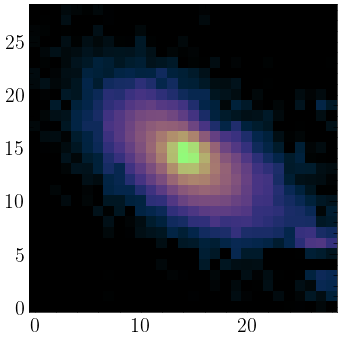

[31.375101 32.38292 ]
<SkyCoord (ICRS): (ra, dec) in deg
    (257.677534, 28.83759983)>


<Figure size 600x450 with 0 Axes>

In [18]:
#Show the point source and host galaxy models
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig=plt.figure(figsize=(4,4))#, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)

y = scene_.sources[indtransient+1].morphology.data
plt.imshow(np.log(y), cmap = cmap,interpolation=int_method,vmin = -4.5)#np.max([np.min(np.log(y)[np.log(y)>-5]),-5]))

plt.savefig(plotdir+'/'+srcname+'_reconstructed_galaxy.pdf')
print(plotdir+'/'+srcname+'_reconstructed_galaxy.pdf')
plt.show()
plt.clf()

centerTDE = scene.sources[indtransient].center
print(centerTDE)
centerTDE_coords = observations_sc2[0].frame.wcs.pixel_to_world(centerTDE[0],centerTDE[1])
print(centerTDE_coords)

(29, 29)


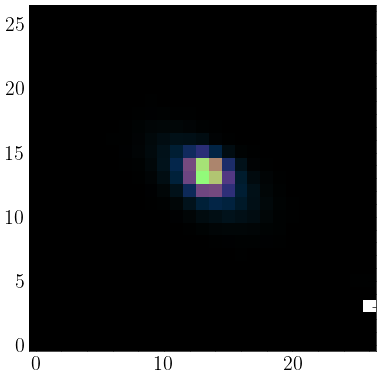

<Figure size 600x450 with 0 Axes>

In [19]:
m, beta, M = np.percentile(y, [0, 50, 60])
I_ = np.clip(y - m, 0, M - m)
f = np.arcsinh(I_ / beta) 
rgb = y/f
#norm = scarlet2.plot.AsinhNorm(m, M, beta)
print(y.shape)
plt.imshow(rgb[1:-1,1:-1],cmap = cmap,interpolation=int_method)
plt.savefig(plotdir+'/'+srcname+'_reconstructed_galaxy_newscaling.pdf')
plt.show()
plt.clf()

In [20]:
from numpyro.infer.initialization import init_to_sample
dosamplinglc=True
    
if dosamplinglc==True:
    parameters = scene_.make_parameters()
    
    p = scene_.sources[indtransient+1].morphology.data
    prior = dist.Normal(p, scale=0.2)
    parameters += Parameter(p, name=f"morphology.data:"+str(indtransient+1), prior=prior)
    p = scene_.sources[indtransient+1].spectrum.data
    prior = dist.Normal(p, scale=2.0)
    parameters += Parameter(p, name=f"spectrum:"+str(indtransient+1), prior=prior)
    p = scene_.sources[indtransient].spectrum.data
    prior = dist.Normal(p, scale=1.0)
    parameters += Parameter(p, name=f"spectrum:"+str(indtransient), prior=prior)
    p = scene_.sources[indtransient].center
    prior = dist.Normal(p, scale=1.0)
    parameters += Parameter(p, name=f"center:"+str(indtransient), prior=prior)
    mcmc = scene_.sample(observations_sc2,parameters,num_warmup=500, num_samples=1500, dense_mass=True, init_strategy=init_to_sample) 
    print(mcmc.get_samples())
    #Get point source position and uncertainties
    q = mcmc.get_samples()['center:'+str(indtransient)] 
    q1 = np.percentile(q,[50-99.73/2,16,50,84,50+99.73/2],axis=0)
    centerAGN = np.asfarray([q1[2,0],q1[2,1]])
    errorAGN = np.asarray([np.abs(q1[4,0]-q1[0,0])/2, np.abs(q1[4,1]-q1[0,1])/2 ])
   

sample: 100%|██████████| 2000/2000 [19:34<00:00,  1.70it/s, 31 steps of size 1.35e-01. acc. prob=0.85]   


{'center:2': Array([[32.19194 , 31.836351],
       [32.197422, 31.840181],
       [32.198708, 31.84105 ],
       ...,
       [32.18829 , 31.838884],
       [32.190727, 31.833723],
       [32.18861 , 31.828417]], dtype=float32), 'morphology.data:3': Array([[[ 0.00990107,  0.00925757, -0.01046584, ...,  0.02145896,
          0.02191208,  0.02373383],
        [ 0.00476875,  0.00780566, -0.00305805, ...,  0.03771416,
          0.03393222,  0.0457214 ],
        [ 0.00435292, -0.00093817,  0.01234178, ...,  0.03093933,
          0.0620718 ,  0.05602489],
        ...,
        [ 0.02513907,  0.01572353,  0.00924058, ..., -0.00404981,
          0.00534092,  0.0068927 ],
        [ 0.01652801,  0.0271477 ,  0.0203933 , ..., -0.00409577,
          0.00509743,  0.01393632],
        [ 0.01226839,  0.01398349,  0.00182079, ..., -0.0012872 ,
          0.00571344,  0.01591456]],

       [[ 0.00509145,  0.00645981,  0.00118186, ...,  0.01459383,
          0.02040618,  0.0127098 ],
        [ 0.00375536, 

/scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_transientcorner_posonly.pdf


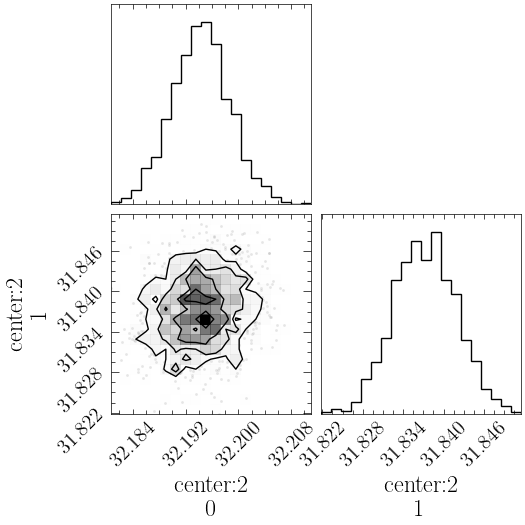

/scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_transientcorner_posSEDonly.pdf


<Figure size 600x450 with 0 Axes>

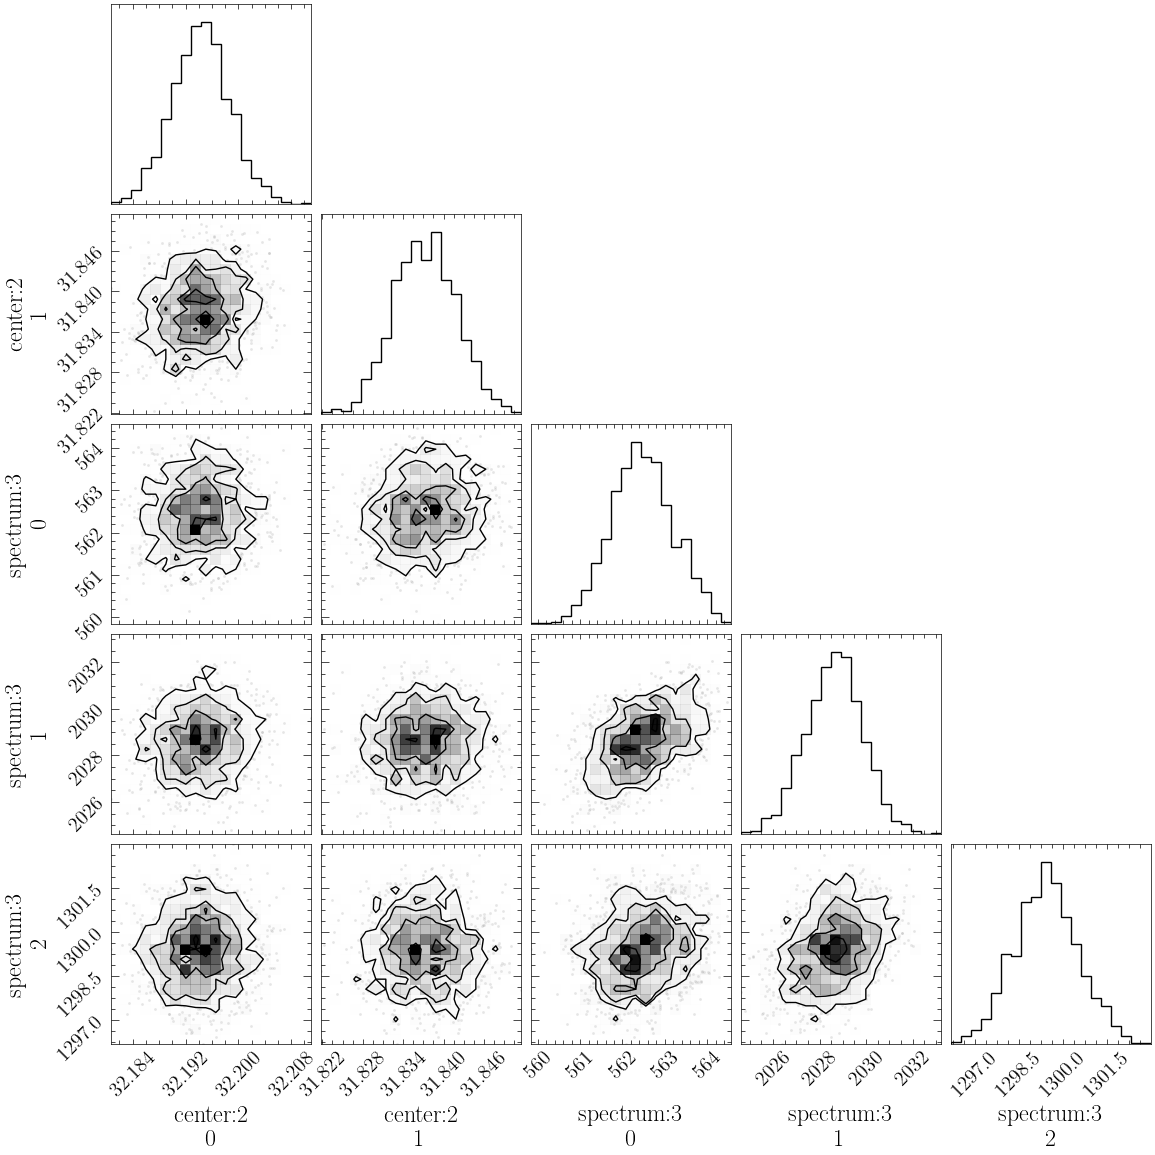

"\ncorner.corner(mcmc,var_names=['center:2','spectrum:2','spectrum:3']).show()\nplt.savefig(plotdir+'/'+srcname+'_transientcorner_posfluxonly.pdf')\nprint(plotdir+'/'+srcname+'_transientcorner_posfluxonly.pdf')\nplt.show()\nplt.clf()\n\ncorner.corner(mcmc).show()\nplt.savefig(plotdir+'/'+srcname+'_transientcorner.pdf')\nprint(plotdir+'/'+srcname+'_transientcorner.pdf')\nplt.show()\nplt.clf()\n"

<Figure size 600x450 with 0 Axes>

In [21]:
corner.corner(mcmc,var_names=['center:2']).show()
plt.savefig(plotdir+'/'+srcname+'_transientcorner_posonly.pdf')
print(plotdir+'/'+srcname+'_transientcorner_posonly.pdf')
plt.show()
plt.clf()
corner.corner(mcmc,var_names=['center:2','spectrum:3']).show()
plt.savefig(plotdir+'/'+srcname+'_transientcorner_posSEDonly.pdf')
print(plotdir+'/'+srcname+'_transientcorner_posSEDonly.pdf')
plt.show()
plt.clf()
'''
corner.corner(mcmc,var_names=['center:2','spectrum:2','spectrum:3']).show()
plt.savefig(plotdir+'/'+srcname+'_transientcorner_posfluxonly.pdf')
print(plotdir+'/'+srcname+'_transientcorner_posfluxonly.pdf')
plt.show()
plt.clf()

corner.corner(mcmc).show()
plt.savefig(plotdir+'/'+srcname+'_transientcorner.pdf')
print(plotdir+'/'+srcname+'_transientcorner.pdf')
plt.show()
plt.clf()
'''




In [22]:
from numpyro.infer.initialization import init_to_sample
import copy
parameters = scene_.make_parameters()
p = scene_.sources[indtransient].center

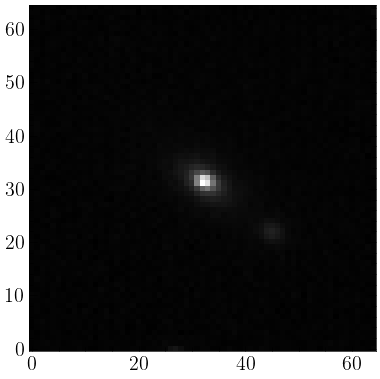

In [23]:
#Subtract all rendered models except the host galaxy from the images so they can be stacked
observations_sc2_arr = np.asarray(observations_sc2)
obs_subtracted=[]
bandselect = []
for i,(chan,obs) in enumerate(zip(channels_sc2,observations_sc2_arr)):
    if channels_sc2[i] in channels_zeroed:
        continue
    bandselect.append(bandind[i])
    newdata = copy.deepcopy(np.asarray(obs.data)) 
    for isource,src in enumerate(scene_.sources):
        continue
        if isource==indtransient+1:
            continue
        model_ = obs.render(scene_.sources[isource]())
        boxslice = scene_.sources[isource].bbox.slices
        overlap1,overlap2 = bbox.overlap_slices(scene_.sources[indtransient].bbox, scene_.sources[isource].bbox)
        try:
            newdata[boxslice] = newdata[boxslice] - model_
        except TypeError:
            print('Slicing operation failure',i,isource)
    plt.imshow(newdata[0])
    obs2 = scarlet2.Observation(jnp.asarray(newdata), jnp.asarray(obs.weights), psf=scarlet2.ArrayPSF(jnp.asarray(obs.frame.psf())),channels=obs.frame.channels)
    #obs2.match(model_frame_sc2)
    obs_subtracted.append(obs2)
obs_subtractedarr = np.asarray(obs_subtracted)

In [24]:
#Stack to make a single gri observation
multichannel = []
multiimage=[]
multivar=[]
multipsf=[]
for i in range(len(['g','i','r'])):
    bind = np.argwhere(np.asarray(bandselect)==i)[:,0]
    if len(bind)==0:
        continue
    weights = np.asarray([obs.weights for obs in obs_subtractedarr[bind]])
    weights[weights==0] = 1e-10
    multivar.append(np.average(np.asarray([obs.weights for obs in obs_subtractedarr[bind]]),axis=0,weights=weights)[0]/np.sqrt(len(obs_subtractedarr[bind]))/100)
    multiimage.append(np.average(np.asarray([obs.data for obs in obs_subtractedarr[bind]]),axis=0,weights=weights)[0])   
    multipsf.append(np.average(np.asarray([obs.frame.psf() for obs in obs_subtractedarr[bind]]),axis=0)[0])
    channel_sc2 = bandall[i]   
    multichannel.append(channel_sc2)
    
obs_sc2 = scarlet2.Observation(jnp.asarray(multiimage), jnp.asarray(multivar),psf=scarlet2.ArrayPSF(jnp.asarray(multipsf)),channels=multichannel)#,wcs=w)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((np.asarray(multiimage).shape[0],np.asarray(multiimage).shape[-1],np.asarray(multiimage).shape[-2])), psf=frame_psf_sc2, channels=multichannel)


Saved /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_transientsubtractedimage.pdf


<Figure size 400x400 with 0 Axes>

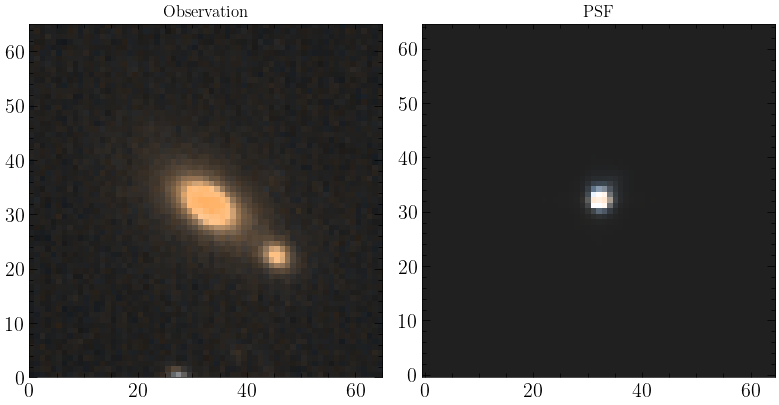

In [25]:
norm = LinearPercentileNorm(obs.data[-1,10:-10,10:-10],percentiles=[0.01, 98])
plt.figure(figsize=(4,4))
scarlet2.plot.observation(obs_sc2,norm=norm,show_psf=True,add_labels=False)
plt.savefig(plotdir+'/'+srcname+'_transientsubtractedimage.pdf')
print('Saved',plotdir+'/'+srcname+'_transientsubtractedimage.pdf')

In [26]:
#Initialize a model with a single Sersic galaxy profile at the host galaxy position for centroid measurement
stepnum=1000
with scarlet2.Scene(model_frame_sc2) as scene3:
    for i,pos in enumerate(ra_dec[0]):  
        coord = SkyCoord(pos[0],pos[1],unit="deg")
        pospix = np.asarray(observations_sc2_init[0].frame.wcs.world_to_pixel(coord),dtype=int)
        centerpix = jnp.asarray(np.asfarray([pospix[1],pospix[0]]))
        center = centerpix#+1
        print(pos,'CENTER',center,centerpix)
        if i==indtransient:
            flux = initialization.pixel_spectrum(obs_sc2, center)
            sersic = scarlet2.SersicMorphology(
                                        #center = jnp.asarray(np.asfarray(centerpix)),
                                        ellipticity = jnp.asarray([0.2,-0.5]),        
                                        size= jnp.asarray(3.5),
                                        n=jnp.asarray(2.2),
                        )
            scarlet2.Source(
                center,
                flux,sersic)
            
parameters = scene3.make_parameters()
step = lambda p: scarlet2.relative_step(p, factor=1e-4)
stepbig = lambda p: scarlet2.relative_step(p, factor=1e-3)
for i in range(len(scene3.sources)):   
    parameters += Parameter(scene3.sources[i].spectrum.data, name=f"spectrum.{i}", constraint=constraints.positive, stepsize=step)#gal_step)
    parameters += Parameter(scene3.sources[i].center, name=f"morph.center.{i}", constraint=constraints.positive, stepsize=stepbig)
    parameters += Parameter(scene3.sources[i].morphology.ellipticity, name=f"morph.ellipticity.{i}", constraint=constraints.interval(-1,1), stepsize=step)
    parameters += Parameter(scene3.sources[i].morphology.size, name=f"morph.size.{i}", constraint=constraints.interval(1.0,6.0), stepsize=step)
    parameters += Parameter(scene3.sources[i].morphology.n, name=f"morph.n.{i}", constraint=constraints.interval(.5,10), stepsize=step) 
 

[257.67897074  28.82862596] CENTER [ 0. 26.] [ 0. 26.]
[257.67317507  28.83462889] CENTER [21. 44.] [21. 44.]
[257.67721068  28.83731756] CENTER [31. 32.] [31. 32.]


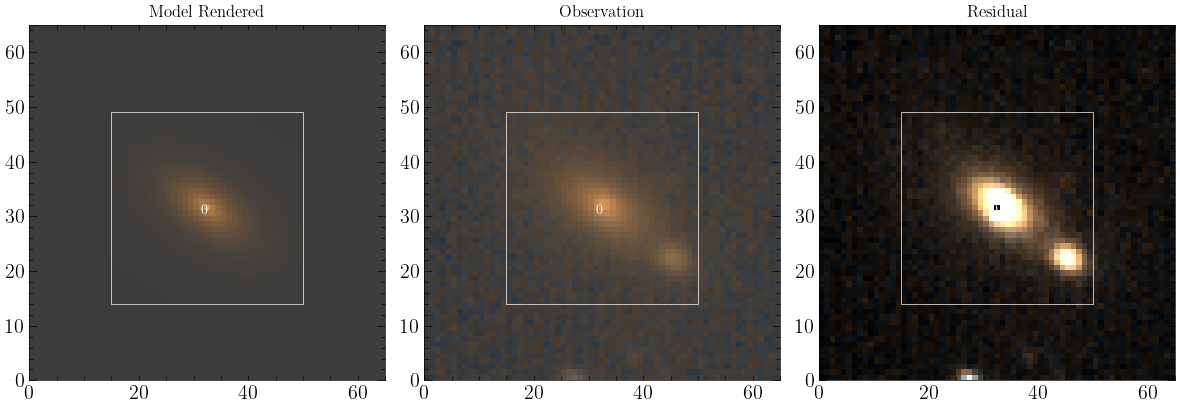

In [27]:
scarlet2.plot.scene(
    scene3,
    observation=obs_sc2,
    norm=normsingle[0],
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
plt.show()

Saved /scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_sersicmodel.pdf


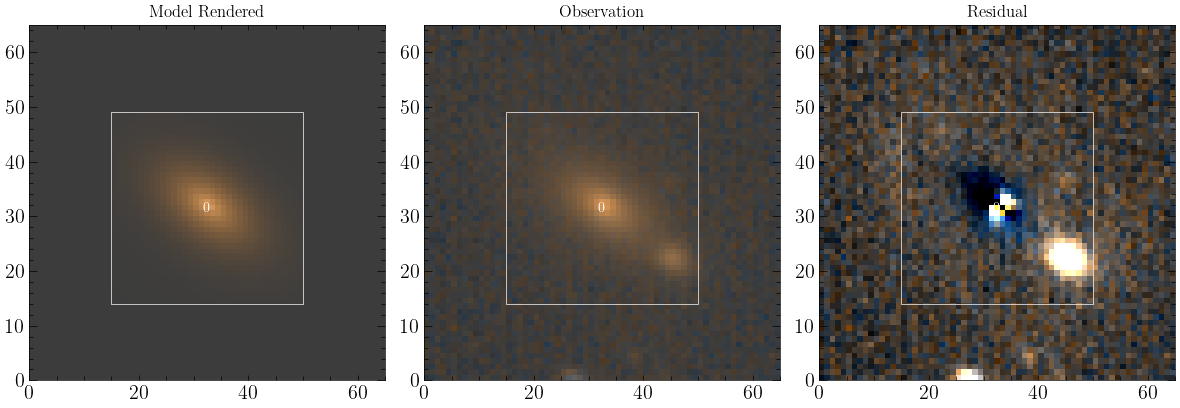

<Figure size 600x450 with 0 Axes>

In [28]:
scene3_ = scene3.fit(obs_sc2,parameters, max_iter=stepnum, e_rel=1e-6,progress_bar=False)#, schedule=schedule)
model_ = obs_sc2.render(scene3_())
scarlet2.plot.scene(
    scene3_,
    observation=obs_sc2,
    norm=normsingle[0],
    channel_map=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    linear=True,
)
print('Saved',plotdir+'/'+srcname+'_sersicmodel.pdf')
plt.show()
plt.clf()

sample: 100%|██████████| 2000/2000 [00:04<00:00, 414.28it/s, 15 steps of size 4.00e-01. acc. prob=0.88] 


/scratch/gpfs/cw1074/ZTFimages/ZTF22aaigqsr/plots/ZTF22aaigqsr_galcenter_corner.pdf


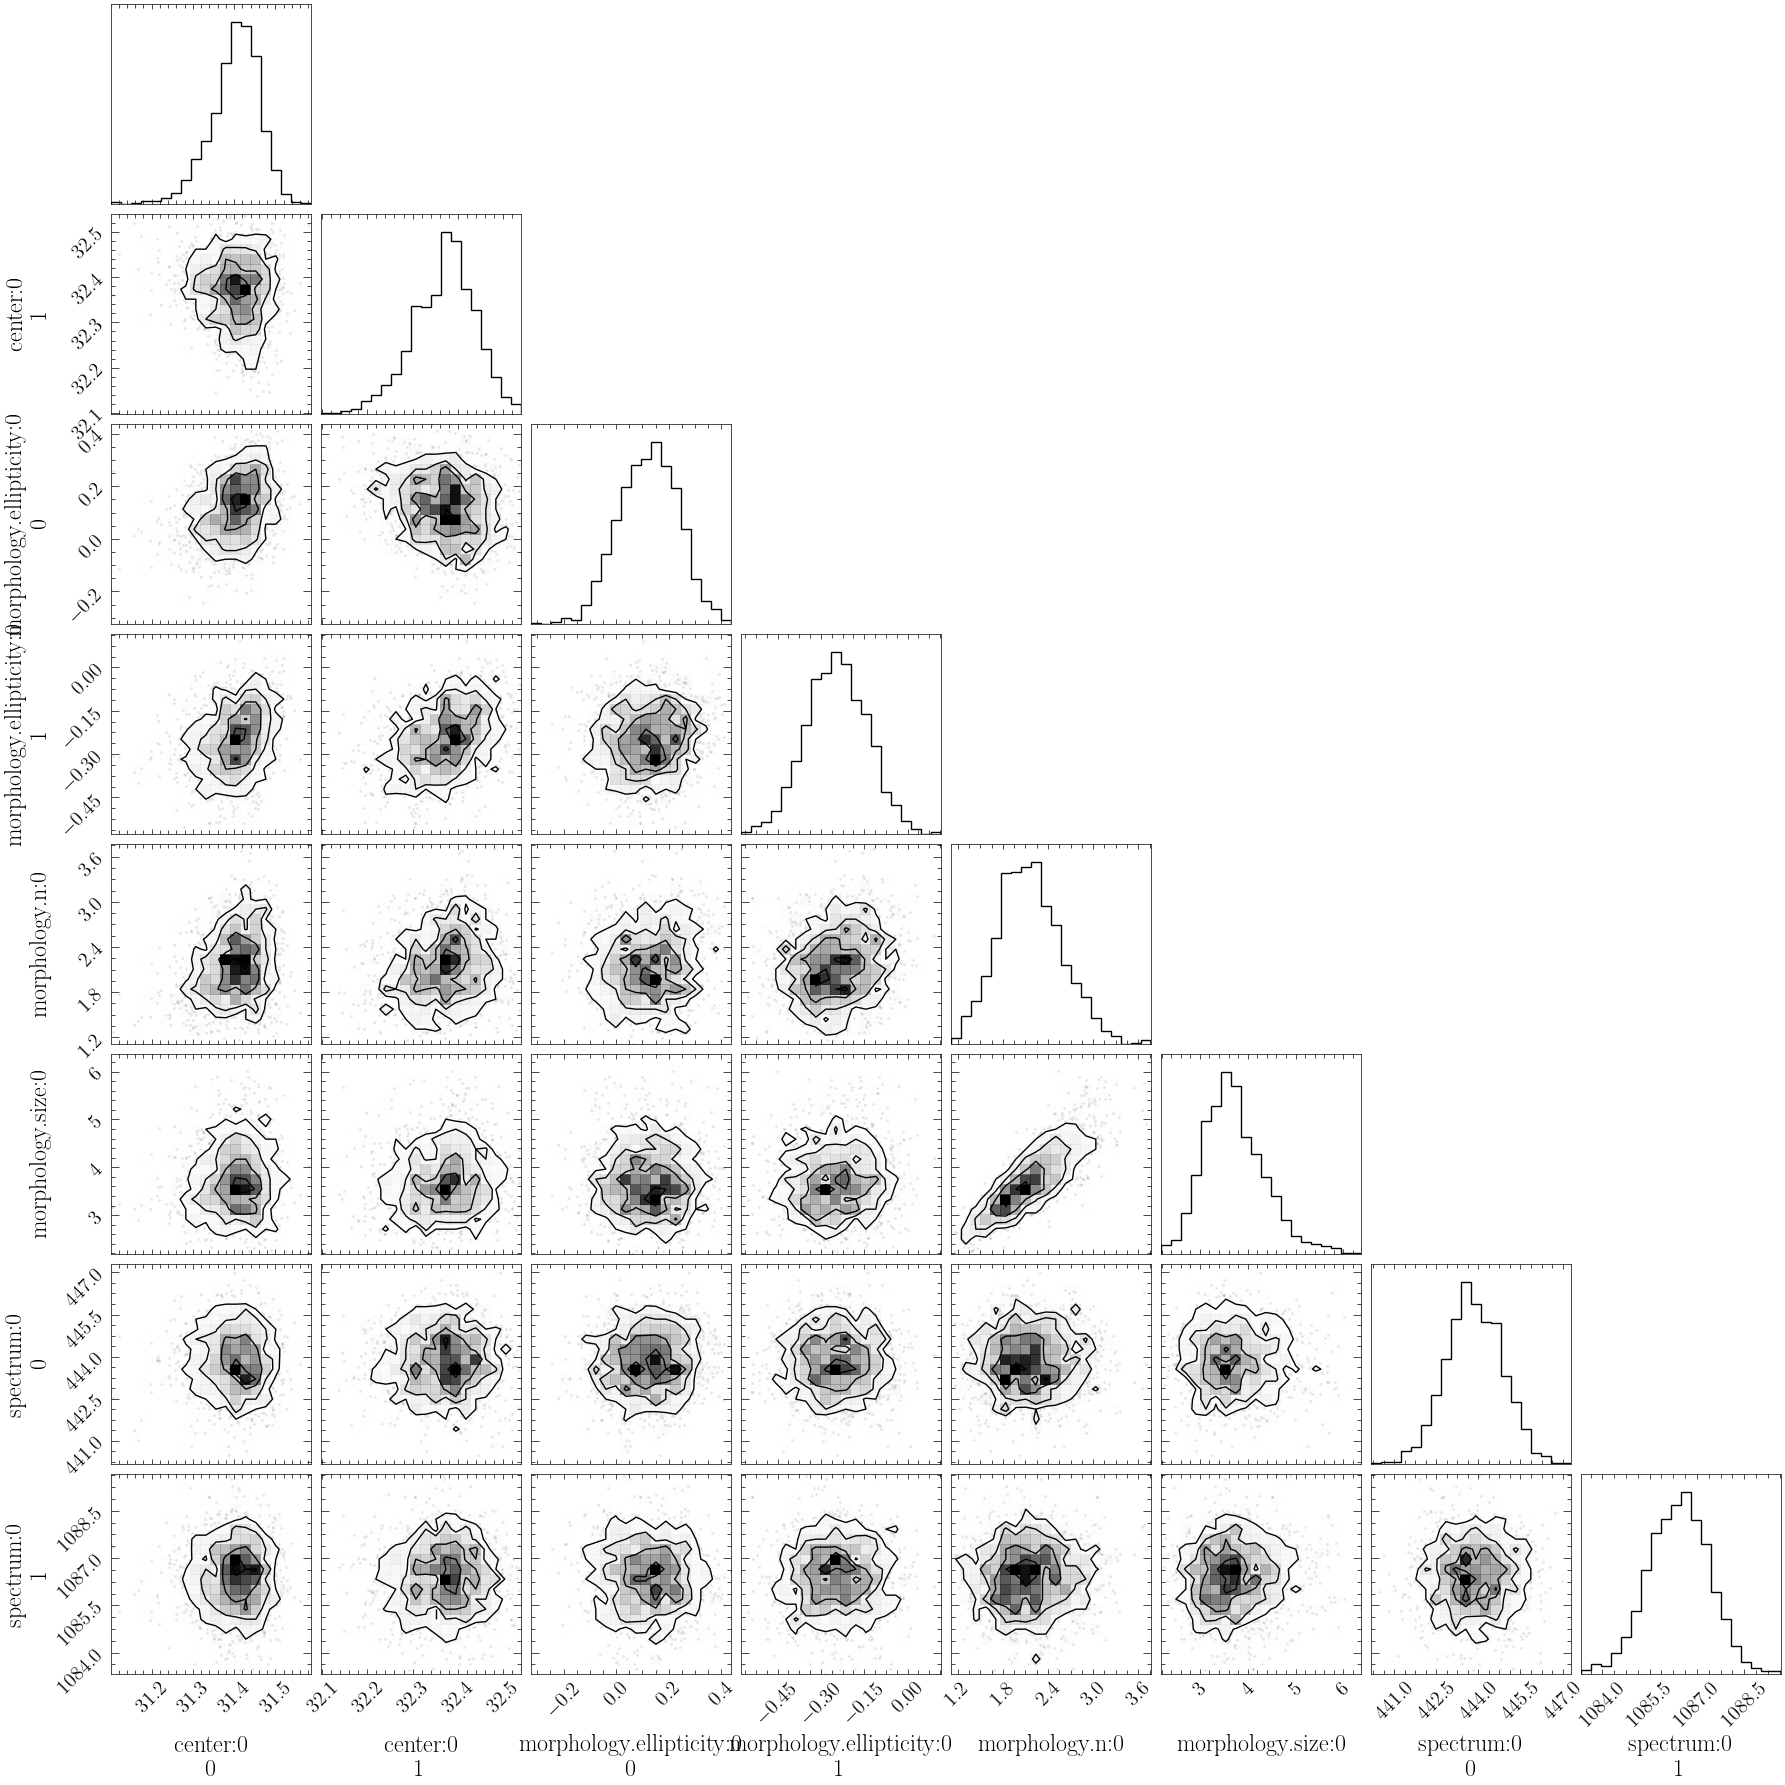

<Figure size 600x450 with 0 Axes>

In [29]:
parameters = scene3_.make_parameters()
p = scene3_.sources[0].center
prior = dist.Normal(p, scale=1)
parameters += Parameter(p, name=f"center:"+str(0), prior=prior)
p = scene3_.sources[0].morphology.ellipticity
parameters += Parameter(p, name=f"morphology.ellipticity:"+str(0), prior=dist.Normal(p, scale=1))
p = scene3_.sources[0].morphology.size
parameters += Parameter(p, name=f"morphology.size:"+str(0), prior=dist.Normal(p, scale=1))
p = scene3_.sources[0].morphology.n
parameters += Parameter(p, name=f"morphology.n:"+str(0), prior=dist.Normal(p, scale=1))
p = scene3_.sources[0].spectrum.data
parameters += Parameter(p, name=f"spectrum:"+str(0), prior=dist.Normal(p, scale=1))


mcmc = scene3_.sample(obs_sc2,parameters,num_warmup=500, num_samples=1500,dense_mass=True, init_strategy=init_to_sample) 
q = mcmc.get_samples()['center:'+str(0)] 
q1 = np.percentile(q,[50-99.73/2,16,50,84,50+99.73/2],axis=0)
centergal = np.asfarray([q1[2,0],q1[2,1]])
errorgal = np.asarray([np.abs(q1[4,0]-q1[0,0]),np.abs(q1[4,1]-q1[0,1])])
corner.corner(mcmc).show() 
plt.savefig(plotdir+'/'+srcname+'_galcenter_corner.pdf')
print(plotdir+'/'+srcname+'_galcenter_corner.pdf')
plt.show()
plt.clf()


In [30]:
centergal_coords = observations_sc2[0].frame.wcs.pixel_to_world(centergal[1],centergal[0])
print(centergal_coords)
centerAGN_coords = observations_sc2[0].frame.wcs.pixel_to_world(centerAGN[1],centerAGN[0])
print(centerAGN_coords)

<SkyCoord (ICRS): (ra, dec) in deg
    (257.67721339, 28.8373262)>
<SkyCoord (ICRS): (ra, dec) in deg
    (257.67738589, 28.83754713)>


In [31]:
PS1gal_pix = observations_sc2[0].frame.wcs.world_to_pixel(SkyCoord(257.677229*u.deg, 28.837314*u.deg, frame='icrs'))
print(PS1gal_pix)
PS1TDE_pix = observations_sc2[0].frame.wcs.world_to_pixel(SkyCoord(257.6773910*u.deg, 28.8375306*u.deg,frame='icrs'))
print(PS1TDE_pix)

(array(32.32570597), array(31.36249683))
(array(31.82118022), array(32.13539307))


In [32]:
offset = np.linalg.norm(centergal - centerAGN)
dx = centerAGN[0]-centergal[0]
dy = centerAGN[1]-centergal[1]

sigx = errorAGN[0]/centerAGN[0]+errorgal[0]/centergal[0]
sigy = errorAGN[1]/centerAGN[1]+errorgal[1]/centergal[1]

error = np.sqrt(1/offset**2*(dx**2*(errorAGN[0]**2+errorgal[0]**2)+dy**2*(errorAGN[1]**2+errorgal[1]**2)))
errorpix = errorAGN+errorgal

print('Offset',[offset,error,float(centerAGN[0]),float(centerAGN[1]),centergal[0],centergal[1]])
np.savetxt(plotdir+'/offset.txt',np.asarray([offset,error,float(centerAGN[0]),float(centerAGN[1]),centergal[0],centergal[1]],dtype=str),fmt='%s')

Offset [0.9540503773927758, 0.4245284696963071, 32.19427490234375, 31.837241172790527, 31.405887603759766, 32.37450981140137]


[0.4382064  0.39283841] [0.00012172 0.00010912] [0.01217562 0.0131838 ] [3.38211597e-06 3.66216660e-06]


/tmp/ipykernel_3210922/1302501391.py:5: RuntimeWarning: invalid value encountered in log
  ax.imshow(np.log(obs_sc2.data[600]),cmap = cmap,interpolation=int_method,vmin = -0)


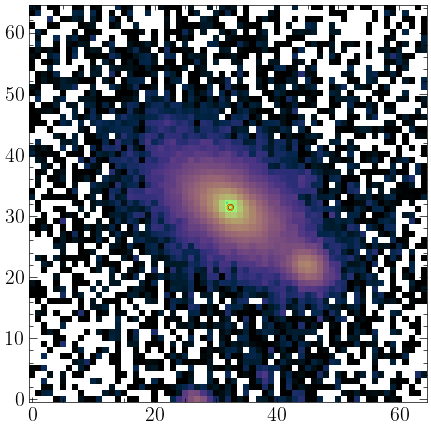

In [33]:
from matplotlib.patches import Circle
fig,ax = plt.subplots(1)
ax.set_aspect('equal')
print(errorgal,errorgal/60/60,errorAGN,errorAGN/60/60)
ax.imshow(np.log(obs_sc2.data[600]),cmap = cmap,interpolation=int_method,vmin = -0)
circ = Circle((centergal[1],centergal[0]),np.max(errorgal),fill=None,edgecolor='black')
ax.add_patch(circ)
circ = Circle((centerAGN[1],centerAGN[0]),np.max(errorAGN),fill=None,edgecolor='C0')
ax.add_patch(circ)
circ = Circle((PS1gal_pix[0],PS1gal_pix[1]),np.max(errorgal),fill=None,edgecolor='C1')
ax.add_patch(circ)
circ = Circle((PS1TDE_pix[0],PS1TDE_pix[1]),np.max(errorAGN),fill=None,edgecolor='C2')
ax.add_patch(circ)
fig.tight_layout()
plt.show()